##### Test

In [4]:
%%html
<style>
.nbviewer div.output_area {
  overflow-y: auto;
  max-height: 500px; /* or value of your choosing */
}
</style>

# `ShakeNBreak` applied to Cd vacancies in CdTe ($V_{Cd}$)

In this notebook we follow the full `ShakeNBreak` (`SnB`) workflow, where we:
- Apply the defect distortions
- Parse the geometry relaxation results
- Re-generate any energy-lowering distortions found for _some_ (but not all) charge states for a given defect
- Plot the final energies to demonstrate what energy-lowering defect distortions have been identified
- Then continue our defect calculations, confident we have obtained the ground-state structures. 

## Table of contents
* [Generate defects with doped/pymatgen](#generate)
* [Apply SnB to defects](#SnB)
* [Send to HPCs and run calculations](#HPCs)
* [Plot energies of final structures](#plot)
* [Analyse defect distortions](#analyse)

In [2]:
import sys
import os
import doped
import pymatgen
import ase
import shakenbreak
import numpy as np
from importlib.metadata import version

# check versions
print("Doped version:" , version('doped') )
print("Pymatgen version:" , version('pymatgen') )
print("Ase version:" , version('ase') )
print("ShakeNBreak version:" , version('shakenbreak') )

Doped version: 0.0.9
Pymatgen version: 2022.7.25
Ase version: 3.22.1
ShakeNBreak version: 1.0.0


<a id='generate'></a>

## 1. Generate defects with `doped`/`pymatgen`

In [66]:
from doped.pycdt.core.defectsmaker import ChargedDefectsStructures
from pymatgen.core.structure import Structure

# Specify perfect (bulk) supercell structure
bulk_supercell = Structure.from_file("../tests/data/vasp/CdTe/CdTe_Bulk_Supercell_POSCAR")  

# Let's generate the vacancies
def_structs = ChargedDefectsStructures(
    bulk_supercell,
    cellmax=bulk_supercell.num_sites,
    antisites_flag=False,
    include_interstitials=False,
)

Setting up vacancies

Number of jobs created:
    bulk = 1
    vacancies:
        vac_1_Cd = 5 with site multiplicity 32
        vac_2_Te = 5 with site multiplicity 32
    substitutions:
Total (non dielectric) jobs created = 11



In [67]:
defect_dict = def_structs.defects
# only using these species for example purpose:
V_Cd_dict = {"vacancies": [defect_dict["vacancies"][0]]}
V_Cd_dict["vacancies"][0]["charges"] = [0,]

#### Rationale for `SnB`   

Defect distortions often follow the change in electron count when introducing that defect to the system. For the neutral Cd vacancy ($V_{Cd}^0$) for example, the removal of Cd and its two valence electrons means that local distortions are likely to involve two neighbouring Te atoms moving closer/further apart to accommodate the broken bonds. For the singly-charged vacancy, we are likely to have just one neighbouring Te moving, etc.

So, the `SnB` method involves distorting the initial bond lengths around the defect for a mesh of trial distortions, with the number of neighbours to distort dictated by the change in valence electron count, performing coarse $\Gamma$-only (`vasp_gam`) relaxations and then comparing the final energies, to see if we identify any lower energy defect structures.

<a id='SnB'></a>

## 2. Apply the `SnB` method to your defects

The default settings and parameter choices in this package have been tested and have performed best thus far (i.e. wider distortion ranges leading to the ground-state structure with lowest computational cost) – this data will be shown in an forthcoming publication. 

If you encounter improved performance with non-default parameter choices, we'd love to know! Please get in touch via GitHub or by email: sean.kavanagh.19@ucl.ac.uk & i.mosquera-lois22@imperial.ac.uk

##### A Note for Hard / Ionic / Oxide / Close-Packed / Small Bond Length (< 2.5 Å) Systems:

> The standard deviation (`std_dev`) controls the magnitude of the random perturbations applied to the structures. For materials with bond distances in the range ~2.5 - 3.5 Å, the default `std_dev` of 0.25 Å seems to perform best. However, for some strongly-bonded systems it may be too much. 

> If this is the case, it will manifest as high energies for the distorted structures compared to the unperturbed relaxation. If you know your system meets these criteria, you should set `std_dev` = 0.15 Å in `apply_shakenbreak()` below, and `bond_distortions = np.arange(-0.5, 0.501, 0.1)` (default range of ±0.6 too large). 
If you are unsure but suspect this could be an issue for your material, the best strategy is often to begin with the default settings, and then monitor the results of the first few distortion meshes that run; if the final energies are less than or equal to the unperturbed relaxation, then no need to change. Otherwise, you should reduce `std_dev` to 0.15 Å (or 0.05 Å if this choice still causes higher energies). More info on this is given later on.

### 2.1 Generating distorted structures

In [68]:
from shakenbreak import input, energy_lowering_distortions
from shakenbreak.input import Distortions

In [69]:
# In order to determine the number of the defect nearest neighbours to distort
# (based on the change in valence electrons mentioned above), we input the oxidation states
# of the atoms in our material:
oxidation_states = {"Cd": +2, "Te": -2}  # specify atom oxidation states
# If not specified, the code will guess these

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions(
    defects_dict=dict(V_Cd_dict),
    oxidation_states=oxidation_states,
)

In [70]:
# We can check the distortion parameters using some of the class properties
print("Bond distortions:", Dist.bond_distortions)
print("Rattle standard deviation:", Dist.stdev, "A")

Bond distortions: [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
Rattle standard deviation: 0.25 A


In [71]:
# You can restrict the ions that are distorted to a certain element using the keyword distorted_elements
# We can check it using the class attribute
print("User defined elements to distort:", Dist.distorted_elements)
# If None, it means no restrictions so nearest neighbours are distorted

User defined elements to distort: None


To see the optional parameters that can be tuned in the distortion functions, look at the docstrings:

In [72]:
input.Distortions?

Init signature:
input.Distortions(
    defects_dict: dict,
    oxidation_states: Union[dict, NoneType] = None,
    dict_number_electrons_user: Union[dict, NoneType] = None,
    distortion_increment: float = 0.1,
    bond_distortions: Union[list, NoneType] = None,
    local_rattle: bool = True,
    stdev: float = 0.25,
    distorted_elements: Union[dict, NoneType] = None,
    **kwargs,
)
Docstring:     
Class to apply rattle and bond distortion to all defects in `defects_dict`
(in `doped` `ChargedDefectsStructures()` format).
Init docstring:
Setup the distortion parameters
Args:
    defects_dict (:obj:`dict`):
        Dictionary of defects as generated with `doped`
        `ChargedDefectsStructures()`
    oxidation_states (:obj:`dict`):
        Dictionary of oxidation states for species in your material,
        used to determine the number of defect neighbours to distort
        (e.g {"Cd": +2, "Te": -2}). If none is provided, the oxidation
        states will be guessed based on the b

If we're only interested in generating distorted structures, but not in writting `VASP`/other codes input files, we can use the class method `Distortions.apply_distortions()` to do this.

In [73]:
defects_dict, distortion_metadata = Dist.apply_distortions()

Applying ShakeNBreak... Will apply the following bond distortions: ['-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6']. Then, will rattle with a std dev of 0.25 Å 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: 0. Number of distorted neighbours: 2


In [74]:
defects_dict["vac_1_Cd"].keys()

dict_keys(['defect_type', 'defect_site', 'defect_supercell_site', 'defect_multiplicity', 'supercell', 'charges'])

In [75]:
# The output dictionary contains information about each defect:
print("Keys for each defect entry:", defects_dict["vac_1_Cd"].keys())

# As well as the distorted structures for each charge state of all defects
# We can access the distorted structures of vac_1_Cd_0 like this:
print("\nUndistorted and distorted structures:")
defects_dict["vac_1_Cd"]["charges"][0]["structures"]

Keys for each defect entry: dict_keys(['defect_type', 'defect_site', 'defect_supercell_site', 'defect_multiplicity', 'supercell', 'charges'])

Undistorted and distorted structures:


{'Unperturbed': Structure Summary
 Lattice
     abc : 13.086768 13.086768 13.086768
  angles : 90.0 90.0 90.0
  volume : 2241.2856479961474
       A : 13.086768 0.0 0.0
       B : 0.0 13.086768 0.0
       C : 0.0 0.0 13.086768
 PeriodicSite: Cd (0.0000, 0.0000, 6.5434) [0.0000, 0.0000, 0.5000]
 PeriodicSite: Cd (0.0000, 6.5434, 0.0000) [0.0000, 0.5000, 0.0000]
 PeriodicSite: Cd (0.0000, 6.5434, 6.5434) [0.0000, 0.5000, 0.5000]
 PeriodicSite: Cd (6.5434, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
 PeriodicSite: Cd (6.5434, 0.0000, 6.5434) [0.5000, 0.0000, 0.5000]
 PeriodicSite: Cd (6.5434, 6.5434, 0.0000) [0.5000, 0.5000, 0.0000]
 PeriodicSite: Cd (6.5434, 6.5434, 6.5434) [0.5000, 0.5000, 0.5000]
 PeriodicSite: Cd (0.0000, 3.2717, 3.2717) [0.0000, 0.2500, 0.2500]
 PeriodicSite: Cd (0.0000, 3.2717, 9.8151) [0.0000, 0.2500, 0.7500]
 PeriodicSite: Cd (0.0000, 9.8151, 3.2717) [0.0000, 0.7500, 0.2500]
 PeriodicSite: Cd (0.0000, 9.8151, 9.8151) [0.0000, 0.7500, 0.7500]
 PeriodicSite: Cd (6.5434

### 2.2 Generating `VASP` input files for the distorted structures

If we want to generate `VASP` input files, we can use the class method `Distortions.write_vasp_files()` (instead of `Distortions.apply_distortions()`)

In [76]:
Dist.write_vasp_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6']. Then, will rattle with a std dev of 0.25 Å 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: 0. Number of distorted neighbours: 2
There is a previous version of distortion_metadata.json. Will rename old metadata to distortion_metadata_2022-07-28-15-41.json
Combining old and new metadata in distortion_metadata.json.


input.py:158: UserWarning: There was a problem when combining old and new metadata files! Will only write new metadata to ./distortion_metadata.json.


({'vac_1_Cd': {'defect_type': 'vac_1_Cd',
   'defect_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
   'defect_supercell_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
   'defect_multiplicity': 32,
   'supercell': [1, 1, 1],
   'charges': {0: {'structures': {'Unperturbed': Structure Summary
      Lattice
          abc : 13.086768 13.086768 13.086768
       angles : 90.0 90.0 90.0
       volume : 2241.2856479961474
            A : 13.086768 0.0 0.0
            B : 0.0 13.086768 0.0
            C : 0.0 0.0 13.086768
      PeriodicSite: Cd (0.0000, 0.0000, 6.5434) [0.0000, 0.0000, 0.5000]
      PeriodicSite: Cd (0.0000, 6.5434, 0.0000) [0.0000, 0.5000, 0.0000]
      PeriodicSite: Cd (0.0000, 6.5434, 6.5434) [0.0000, 0.5000, 0.5000]
      PeriodicSite: Cd (6.5434, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
      PeriodicSite: Cd (6.5434, 0.0000, 6.5434) [0.5000, 0.0000, 0.5000]
      PeriodicSite: Cd (6.5434, 6.5434, 0.0000) [0.5000, 0.

Using `incar_settings` above, we can specify some custom `INCAR` tags to match our converged `ENCUT` for this system and optimal `NCORE` for the HPC we will run the calculations on. More information on the distortions generated can be obtained by setting `verbose = True`.

Our distorted structures and VASP input files have now been generated in the `vac_1_Cd_X` folders.

And for the default coarse structure-searching `INCAR` settings, either have a look at the `incar.yaml` file in the `input_files` folder or at the generated files:

In [77]:
!cat ./vac_1_Cd_0/Bond_Distortion_-10.0%/INCAR

# May want to change NCORE, KPAR, AEXX, ENCUT, NUPDOWN, ISPIN, POTIM = 
# ShakeNBreak INCAR with coarse settings to maximise speed with sufficient accuracy for qualitative structure searching = 
# KPAR = # No KPAR, only one kpoint
ALGO = Normal
EDIFFG = -0.01
ENCUT = 300
HFSCREEN = 0.2
IBRION = 2 # While often slower than '1' (RMM-DIIS), this is more stable and reliable, and vasp_gam relaxations are typically cheap enough to justify it
ICHARG = 1
ICORELEVEL = 0 # Needed if using the Kumagai-Oba (eFNV) anisotropic charge correction
ISIF = 2
ISMEAR = 0
ISPIN = 2 # Spin polarisation likely for defects
ISYM = 0 # Symmetry breaking extremely likely for defects
LASPH = True
LHFCALC = True
LORBIT = 11
LREAL = False
LVHAR = True # Needed if using the Freysoldt (FNV) charge correction scheme
LWAVE = True
NCORE = 12
NEDOS = 2000
NELM = 100
NSW = 300
PREC = Accurate
PRECFOCK = Fast
SIGMA = 0.05
NELECT = 564.0
NUPDOWN = 0 # But could be 2 if strong spin polarisation or magnetic behaviour present
E

Note that the `NELECT` `INCAR` tag (number of electrons) is automatically determined based on the choice of `POTCAR`s. The default in `ShakeNBreak` is to use the `MPRelaxSet` `POTCAR` choices, but if you're using different ones, make sure to set `potcar_settings` in `apply_shakenbreak()`, so that NELECT is then set accordingly. Note this relies on you having set up `pymatgen` to work with your `POTCAR`s via the `~/.pmgrc.yaml` file, instructions [here](https://pymatgen.org/installation.html#potcar-setup)

### 2.3 *Optional*: Generating `input` files for other codes

In [78]:
from shakenbreak import input, energy_lowering_distortions
from shakenbreak.input import Distortions

#### a) `Quantum Espresso`

In [79]:
# check the arguments of the `write_espresso_files` method
Dist.write_espresso_files?

Signature:
Dist.write_espresso_files(
    pseudopotentials: Union[dict, NoneType] = None,
    input_parameters: Union[str, NoneType] = None,
    write_structures_only: Union[bool, NoneType] = False,
    output_path: str = '.',
    verbose: Union[bool, NoneType] = False,
) -> Tuple[dict, dict]
Docstring:
Generates input files for Quantum Espresso relaxations of all output
structures.

Args:
    pseudopotentials (:obj:`dict`, optional):
        Dictionary matching element to pseudopotential name.
        (Defaults: None)
    input_parameters (:obj:`dict`, optional):
        Dictionary of user Quantum Espresso input parameters, to
        overwrite/update `shakenbreak` default ones (see
        `input_files/qe_input.yaml`).
        (Default: None)
    write_structures_only (:obj:`bool`, optional):
        Whether to only write the structure files (in CIF format)
        (without calculation inputs).
        (Default: False)
    output_path (:obj:`str`, optional):
        Path to directory

In [80]:
oxidation_states = {"Cd": +2, "Te": -2}  # specify atom oxidation states

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions(
    defects_dict=dict(V_Cd_dict),
    oxidation_states=oxidation_states,
    bond_distortions=[0.3,] # For demonstration purposes, just doing 2 distortions
)

pseudopotentials = { # Your chosen pseudopotentials
    'Cd': 'Cd_pbe_v1.uspp.F.UPF',
    'Te': 'Te.pbe-n-rrkjus_psl.1.0.0.UPF'}

defects_dict, distortion_metadata = Dist.write_espresso_files(
    pseudopotentials=pseudopotentials,
)

Applying ShakeNBreak... Will apply the following bond distortions: ['0.3']. Then, will rattle with a std dev of 0.25 Å 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: 0. Number of distorted neighbours: 2


And for the default coarse structure-searching input settings, either have a look at the `qe_input.yaml` file in the `input_files` folder or at the generated files:

In [81]:
!cat ./vac_1_Cd_0/Bond_Distortion_30.0%/espresso.pwi

&CONTROL
   calculation      = 'relax'
   title            = 'espresso'
   nstep            = 300
   tstress          = .false.
   tprnfor          = .true.
/
&SYSTEM
   ibrav            = 0
   tot_charge       = 0
   ecutwfc          = 30.0
   nosym            = .true.
   occupations      = 'smearing'
   degauss          = 0.0015
   nspin            = 2
   input_dft        = 'HSE'
   exx_fraction     = 0.25
   starting_magnetization(1) = 0.0
   starting_magnetization(2) = 0.0
   ntyp             = 2
   nat              = 63
/
&ELECTRONS
   ecutwfc          = 33.0
/
&IONS
/
&CELL
/

ATOMIC_SPECIES
Cd  112.414 Cd_pbe_v1.uspp.F.UPF
Te  127.6 Te.pbe-n-rrkjus_psl.1.0.0.UPF

K_POINTS automatic
1 1 1  0 0 0

CELL_PARAMETERS angstrom
13.08676800000000 0.00000000000000 0.00000000000000
0.00000000000000 13.08676800000000 0.00000000000000
0.00000000000000 0.00000000000000 13.08676800000000

ATOMIC_POSITIONS angstrom
Cd  0.0888947768 0.0954840456 6.5511245395
Cd  0.1538519689 6.5191656398 0.05679

#### b) `CP2K`

In [82]:
Dist.write_cp2k_files?

Signature:
Dist.write_cp2k_files(
    input_file: Union[str, NoneType] = '/home/ireaml/Python_Modules/shakenbreak/shakenbreak/../input_files/cp2k_input.inp',
    write_structures_only: Union[bool, NoneType] = False,
    output_path: str = '.',
    verbose: Union[bool, NoneType] = False,
) -> Tuple[dict, dict]
Docstring:
Generates input files for CP2K relaxations of all output structures.

Args:
    input_file  (:obj:`str`, optional):
        Path to CP2K input file. If not set, default input file will be
        used (see `shakenbreak/input_files/cp2k_input.inp`).
    write_structures_only (:obj:`bool`, optional):
        Whether to only write the structure files (in CIF format)
        (without calculation inputs).
        (Default: False)
    output_path (:obj:`str`, optional):
        Path to directory in which to write distorted defect structures
        and calculation inputs.
        (Default is current directory: ".")
    verbose (:obj:`bool`, optional):
        Whether to print

In [83]:
oxidation_states = {"Cd": +2, "Te": -2}  # specify atom oxidation states

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions( 
            defects_dict=dict(V_Cd_dict), 
            oxidation_states=oxidation_states,
            bond_distortions=[0.3] # For demonstration purposes, just doing 2 distortions
            )

defects_dict, distortion_metadata = Dist.write_cp2k_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['0.3']. Then, will rattle with a std dev of 0.25 Å 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: 0. Number of distorted neighbours: 2


And for the default coarse structure-searching input settings, either have a look at the `cp2k_input.yaml` file in the `input_files` folder or at the generated files:

In [84]:
!cat ./vac_1_Cd_0/Bond_Distortion_30.0%/cp2k_input.inp

&GLOBAL 
	PROJECT relax ! files generated will be named relax.out etc
	RUN_TYPE GEO_OPT ! geometry optimization
	IOLEVEL MEDIUM ! reduce amount of IO
&END GLOBAL
&FORCE_EVAL 
	METHOD Quickstep

	! the electronic structure part
	&DFT 
		BASIS_SET_FILE_NAME HFX_BASIS
		POTENTIAL_FILE_NAME GTH_POTENTIALS
		SPIN_POLARIZED .TRUE.
		CHARGE 0
		&MGRID 
			CUTOFF [eV] 500 ! PW cutoff
		&END MGRID
		&QS 
			METHOD GPW
			EPS_DEFAULT 1e-10
			EXTRAPOLATION ASPC
		&END QS

		! use the GPW method (i.e. pseudopotential
		! basedcalculations with the Gaussian and Plane
		! Wavesscheme)
		&DFT 
			&KPOINTS 
				SCHEME GAMMA 1 1 1 ! Gamma point only
			&END KPOINTS
		&END DFT
		&POISSON 
			PERIODIC XYZ ! the default
		&END POISSON
		&PRINT 

			! at the end of the SCF procedure generate
			! cubefiles of the density
			&E_DENSITY_CUBE OFF
			&END E_DENSITY_CUBE
		&END PRINT

		! use the OT METHOD for robust and efficientSCF,
		! suitable for all non-metallic systems.
		&SCF 
			SCF_GUESS RESTART ! ca

#### c) `CASTEP`

In [85]:
Dist.write_castep_files?

Signature:
Dist.write_castep_files(
    input_file: Union[str, NoneType] = '/home/ireaml/Python_Modules/shakenbreak/shakenbreak/../input_files/castep.param',
    write_structures_only: Union[bool, NoneType] = False,
    output_path: str = '.',
    verbose: Union[bool, NoneType] = False,
) -> Tuple[dict, dict]
Docstring:
Generates input `.cell` files for CASTEP relaxations of all output
structures.

Args:
    input_file (:obj:`str`, optional):
        Path to CASTEP input (`.param`) file. If not set, default input
        file will be used (see `shakenbreak/input_files/castep.param`).
    write_structures_only (:obj:`bool`, optional):
        Whether to only write the structure files (in CIF format)
        (without calculation inputs).
        (Default: False)
    output_path (:obj:`str`, optional):
        Path to directory in which to write distorted defect structures
        and calculation inputs.
        (Default is current directory: ".")
    verbose (:obj:`bool`, optional):
    

In [86]:
oxidation_states = {"Cd": +2, "Te": -2}  # specify atom oxidation states

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions(
    defects_dict=dict(V_Cd_dict),
    oxidation_states=oxidation_states,
    bond_distortions=[0.3] # For demonstration purposes, just doing 2 distortions
)
# If we don't specify the input_file, only the structure files (in .cell format) are written
defects_dict, distortion_metadata = Dist.write_castep_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['0.3']. Then, will rattle with a std dev of 0.25 Å 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: 0. Number of distorted neighbours: 2


And for the default coarse structure-searching input settings, either have a look at the `castep.param` file in the `input_files` folder or at the generated files:

In [87]:
!cat ./vac_1_Cd_0/Bond_Distortion_30.0%/castep.param

#######################################################
#CASTEP param file: /home/ireaml/Python_Modules/shakenbreak/vac_1_Cd_0/Bond_Distortion_30.0%/castep.param
#Created using the Atomic Simulation Environment (ASE)#
# Internal settings of the calculator
# This can be switched off by settings
# calc._export_settings = False
# If stated, this will be automatically processed
# by ase.io.castep.read_seed()
# ASE_INTERFACE _build_missing_pspots : True
# ASE_INTERFACE _castep_command : castep
# ASE_INTERFACE _castep_pp_path : /home/ireaml/Python_Modules/shakenbreak
# ASE_INTERFACE _check_checkfile : True
# ASE_INTERFACE _copy_pspots : False
# ASE_INTERFACE _directory : /home/ireaml/Python_Modules/shakenbreak/vac_1_Cd_0/Bond_Distortion_30.0%
# ASE_INTERFACE _export_settings : True
# ASE_INTERFACE _find_pspots : False
# ASE_INTERFACE _force_write : True
# ASE_INTERFACE _label : castep
# ASE_INTERFACE _link_pspots : True
# ASE_INTERFACE _pedantic : False
# ASE_INTERFACE _prepare_input_only : 

#### d) `FHI-aims`

In [88]:
Dist.write_fhi_aims_files?

Signature:
Dist.write_fhi_aims_files(
    ase_calculator: Union[ase.calculators.aims.Aims, NoneType] = None,
    write_structures_only: Union[bool, NoneType] = False,
    output_path: str = '.',
    verbose: Union[bool, NoneType] = False,
) -> Tuple[dict, dict]
Docstring:
Generates input geometry files for FHI-aims relaxations of all
output structures.

Args:
    ase_calculator (:obj:`ase.calculators.aims.Aims`, optional):
        ASE calculator object to use for FHI-aims calculations.
        If not set, `shakenbreak` default values will be used.
        Recommended to check these.
        (Default: None)
    write_structures_only (:obj:`bool`, optional):
        Whether to only write the structure files (in `geometry.in`
        format), (without the contro-in file).
    output_path (:obj:`str`, optional):
        Path to directory in which to write distorted defect structures
        and calculation inputs.
        (Default is current directory: ".")
    verbose (:obj:`bool`, option

In [89]:
oxidation_states = {"Cd": +2, "Te": -2}  # specify atom oxidation states

# Create an instance of Distortion class with the defect dictionary and the distortion parameters
# If distortion parameters are not specified, the default values are used
Dist = Distortions( 
    defects_dict=dict(V_Cd_dict), 
    oxidation_states=oxidation_states,
    bond_distortions=[0.3] # For demonstration purposes, just doing 2 distortions
)
# If we don't specify the input_file, only the structure files (in .cell format) are written
defects_dict, distortion_metadata = Dist.write_fhi_aims_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['0.3']. Then, will rattle with a std dev of 0.25 Å 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: 0. Number of distorted neighbours: 2


And for the default coarse structure-searching input settings have a look at the generated files:

In [90]:
!cat ./vac_1_Cd_0/Bond_Distortion_30.0%/control.in

#===============================================================================
# FHI-aims file: ./vac_1_Cd_0/Bond_Distortion_30.0%/control.in
# Created using the Atomic Simulation Environment (ASE)
# Thu Jul 28 15:41:34 2022
#===============================================================================
k_grid                             1 1 1
relax_geometry                     bfgs 0.005
xc                                 hse06 0.11
hse_unit                           A
spin                               collinear
default_initial_moment             0
hybrid_xc_coeff                    0.25
charge                             0
#===============================================================================



These can be modified with the `ase_calculator` option of the `Distortion.write_fhi_aims_files()` method

<a id='HPCs'></a>

## 3. Send to HPCs and run relaxations

#### a) For `VASP` users:

Then parse the energies obtained by running the `snb-parse` command from the top-level folder containing your defect folders (e.g. `vac_1_Cd_0` etc. (with subfolders: `vac_1_Cd_0/Bond_Distortion_10.0%` etc.)). This will parse the energies and store them in a `vac_1_Cd_0.yaml` etc file in the defect folders, to allow easy plotting and analysis.

It is also recommended to parse the final structures (`CONTCAR`s files if using `VASP`) obtained with each distortion relaxation for further structural analysis. 

Copying these data to your local PC can be done quickly from your local folder top-level folder (containing `vac_1_Cd_0` etc) with the following code:

```bash
for defect in ./*{_,_-}[0-9]/; do cd $defect; scp {remote_machine}:{path to ShakeNBreak folders}/${defect}${defect%?}.yaml .; for distortion in (Bond_Distortion|Unperturbed|Rattled)*/; do scp {remote_machine}:{path to ShakeNBreak folders}/${defect}${distortion}CONTCAR ${distortion}; done; cd ..; done
```
making sure to change `{remote_machine}` and `{path to ShakeNBreak folders}` to the correct values in your case.

#### b) If using `CP2K`, `Quantum Espresso`, `CASTEP` or `FHI-aims`:
Then parse the energies obtained by running the `snb-parse` command from the top-level folder containing your defect folders (e.g. `vac_1_Cd_0` etc. (with subfolders: `vac_1_Cd_0/Bond_Distortion_10.0%` etc.)) and setting the `--code` option (e.g. `snb-parse --code cp2k`). This will parse the energies and store them in a `vac_1_Cd_0.yaml` etc file in the defect folders, to allow easy plotting and analysis. 

It is also recommended to parse the final structures obtained with each relaxation for further structural analysis. Depending on the code the structure information is read from:
* `CP2K`: restart file
* `Quantum Espresso`: output file
* `CASTEP`: output file (i.e. `.castep`)
* `FHI-aims`: output file

**_For demonstration purposes_** in this example notebook, we'll use some (fake) example data:  
(Don't do this if you're actually running the calculations and have downloaded the data as instructed above)

In [1]:
!cp -r ../tests/data/example_results/* .
!cp ../tests/data/vasp/CdTe/distortion_metadata.json .
# may need to change path if you've moved the example notebook elsewhere

<a id='plot'></a>

## 4. Plot energies vs distortion
To see if `SnB` found any energy-lowering distortions, we can plot the results using the functions in `shakenbreak.plotting`.

In [2]:
from shakenbreak import energy_lowering_distortions, plotting

In [3]:
defect_charges_dict = energy_lowering_distortions.read_defects_directories()
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(defect_charges_dict)


vac_1_Ti
No data parsed for vac_1_Ti_0. This species will be skipped and will not be included in the low_energy_defects charge state lists (and so energy lowering distortions found for other charge states will not be applied for this species).

vac_1_Cd
vac_1_Cd_-1: Energy difference between minimum, found with 0.2 bond distortion, and unperturbed: -0.90 eV.
Energy lowering distortion found for vac_1_Cd with charge -1. Adding to low_energy_defects dictionary.
No energy lowering distortion with energy difference greater than  min_e_diff = 0.05 eV found for vac_1_Cd with charge -2.
vac_1_Cd_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...


analysis.py:250: UserWarning: Path ./vac_1_Ti_0/vac_1_Ti_0.yaml does not exist


New (according to structure matching) low-energy distorted  structure found for vac_1_Cd_0, adding to low_energy_defects['vac_1_Cd'] list.

Comparing and pruning defect structures across charge states...
Comparing structures to specified ref_structure (Cd31 Te32)...
Comparing structures to specified ref_structure (Cd31 Te32)...
Comparing structures to specified ref_structure (Cd31 Te32)...
Comparing structures to specified ref_structure (Cd31 Te32)...


These functions give us some info about whether any energy-lowering defect distortions were identified, and we can see the results clearer by plotting:

plotting.py:754: UserWarning: Path ./vac_1_Ti_0/vac_1_Ti_0.yaml does not exist. Skipping vac_1_Ti_0.


Plot saved to /home/ireaml/Python_Modules/shakenbreak/tutorials/distortion_plots/
Plot saved to /home/ireaml/Python_Modules/shakenbreak/tutorials/distortion_plots/


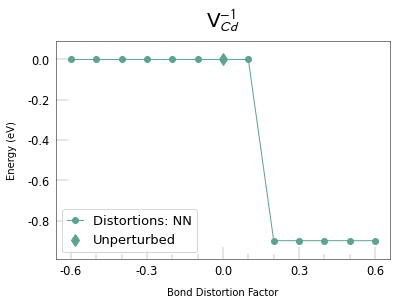

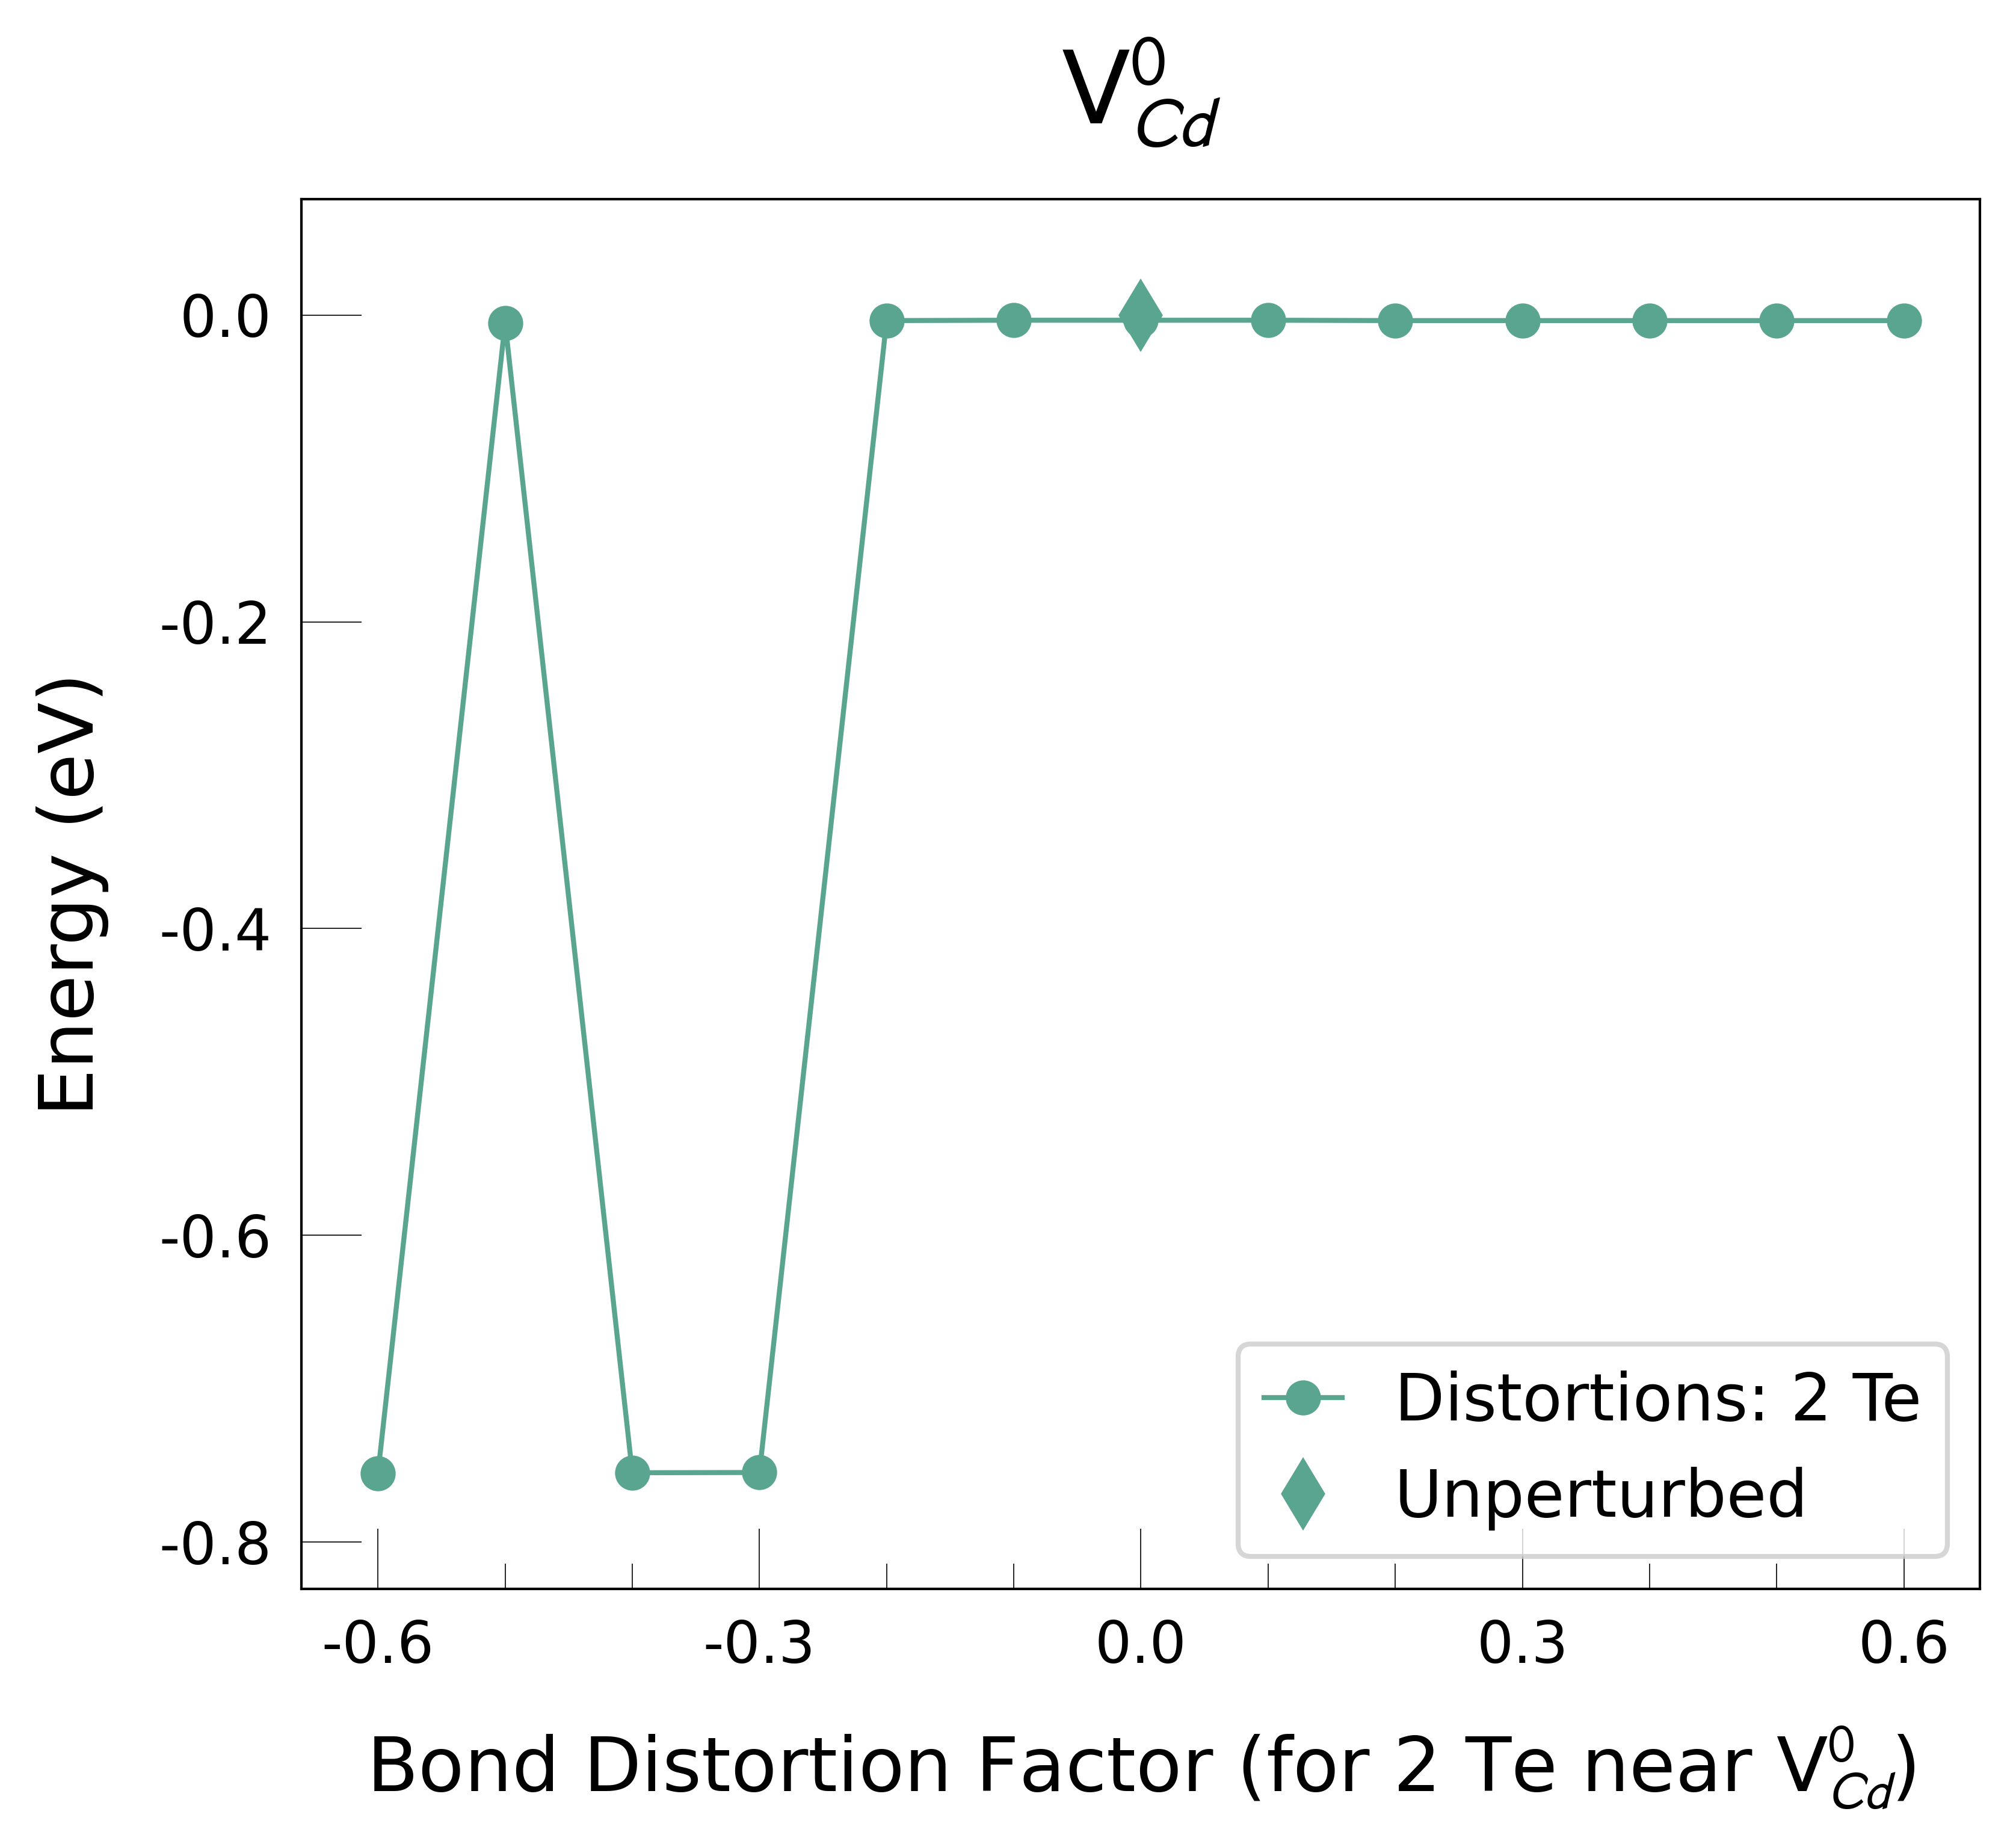

In [4]:
figs = plotting.plot_all_defects(defect_charges_dict)

This prints the distortion plots for all defects where a significant energy lowering distortion, relative to the standard unperturbed relaxation, was identified. The threshold energy difference to consider as 'significant' is controlled by the `min_e_diff` optional parameter (default = 0.05 eV).

### Can also add a colorbar 
These plots can be made more informative by adding a colorbar showing the structural similarity between the relaxed structures.   
For this you need the `CONTCAR`'s obtained with each distortion (as mentioned above).

For the colorbar structure comparison metric, you can either use:
* summed root mean squared displacement (`metric` = `disp`)
* maximum distance between matching sites (`metric` = `max_dist`, default).   

plotting.py:754: UserWarning: Path ./vac_1_Ti_0/vac_1_Ti_0.yaml does not exist. Skipping vac_1_Ti_0.


Comparing structures to Unperturbed...
Plot saved to /home/ireaml/Python_Modules/shakenbreak/tutorials/distortion_plots/
Comparing structures to Unperturbed...
Plot saved to /home/ireaml/Python_Modules/shakenbreak/tutorials/distortion_plots/


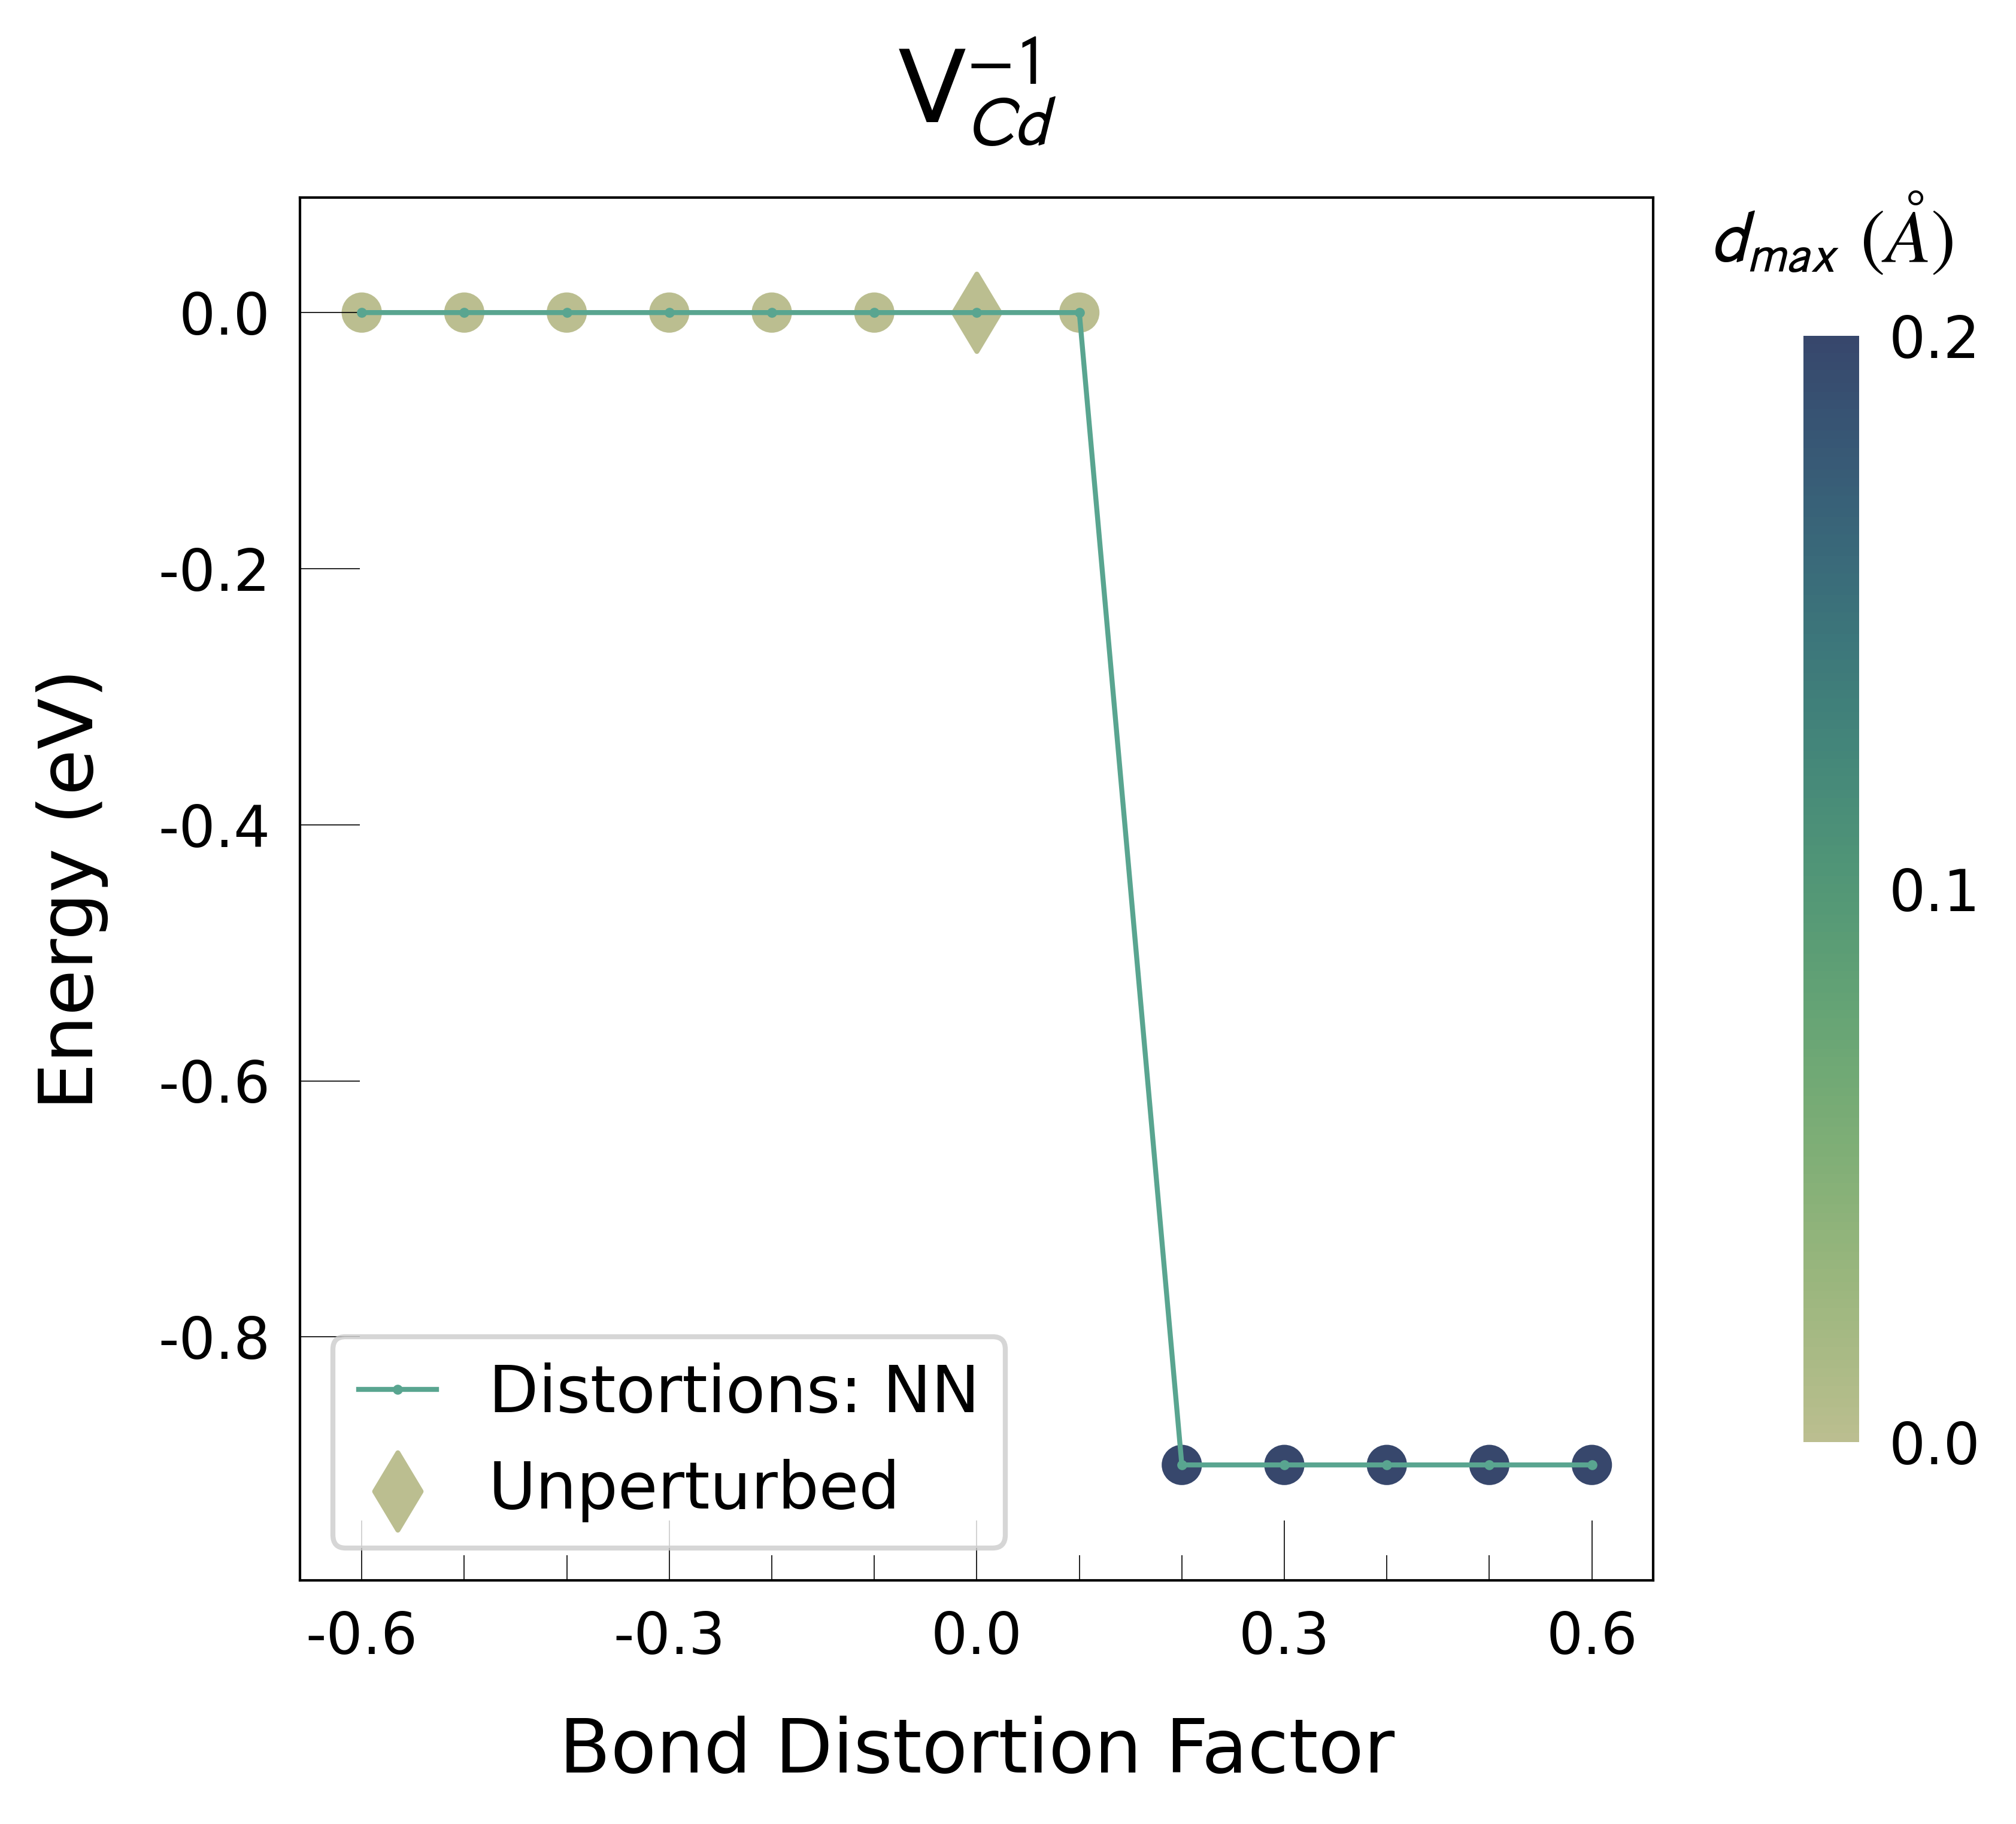

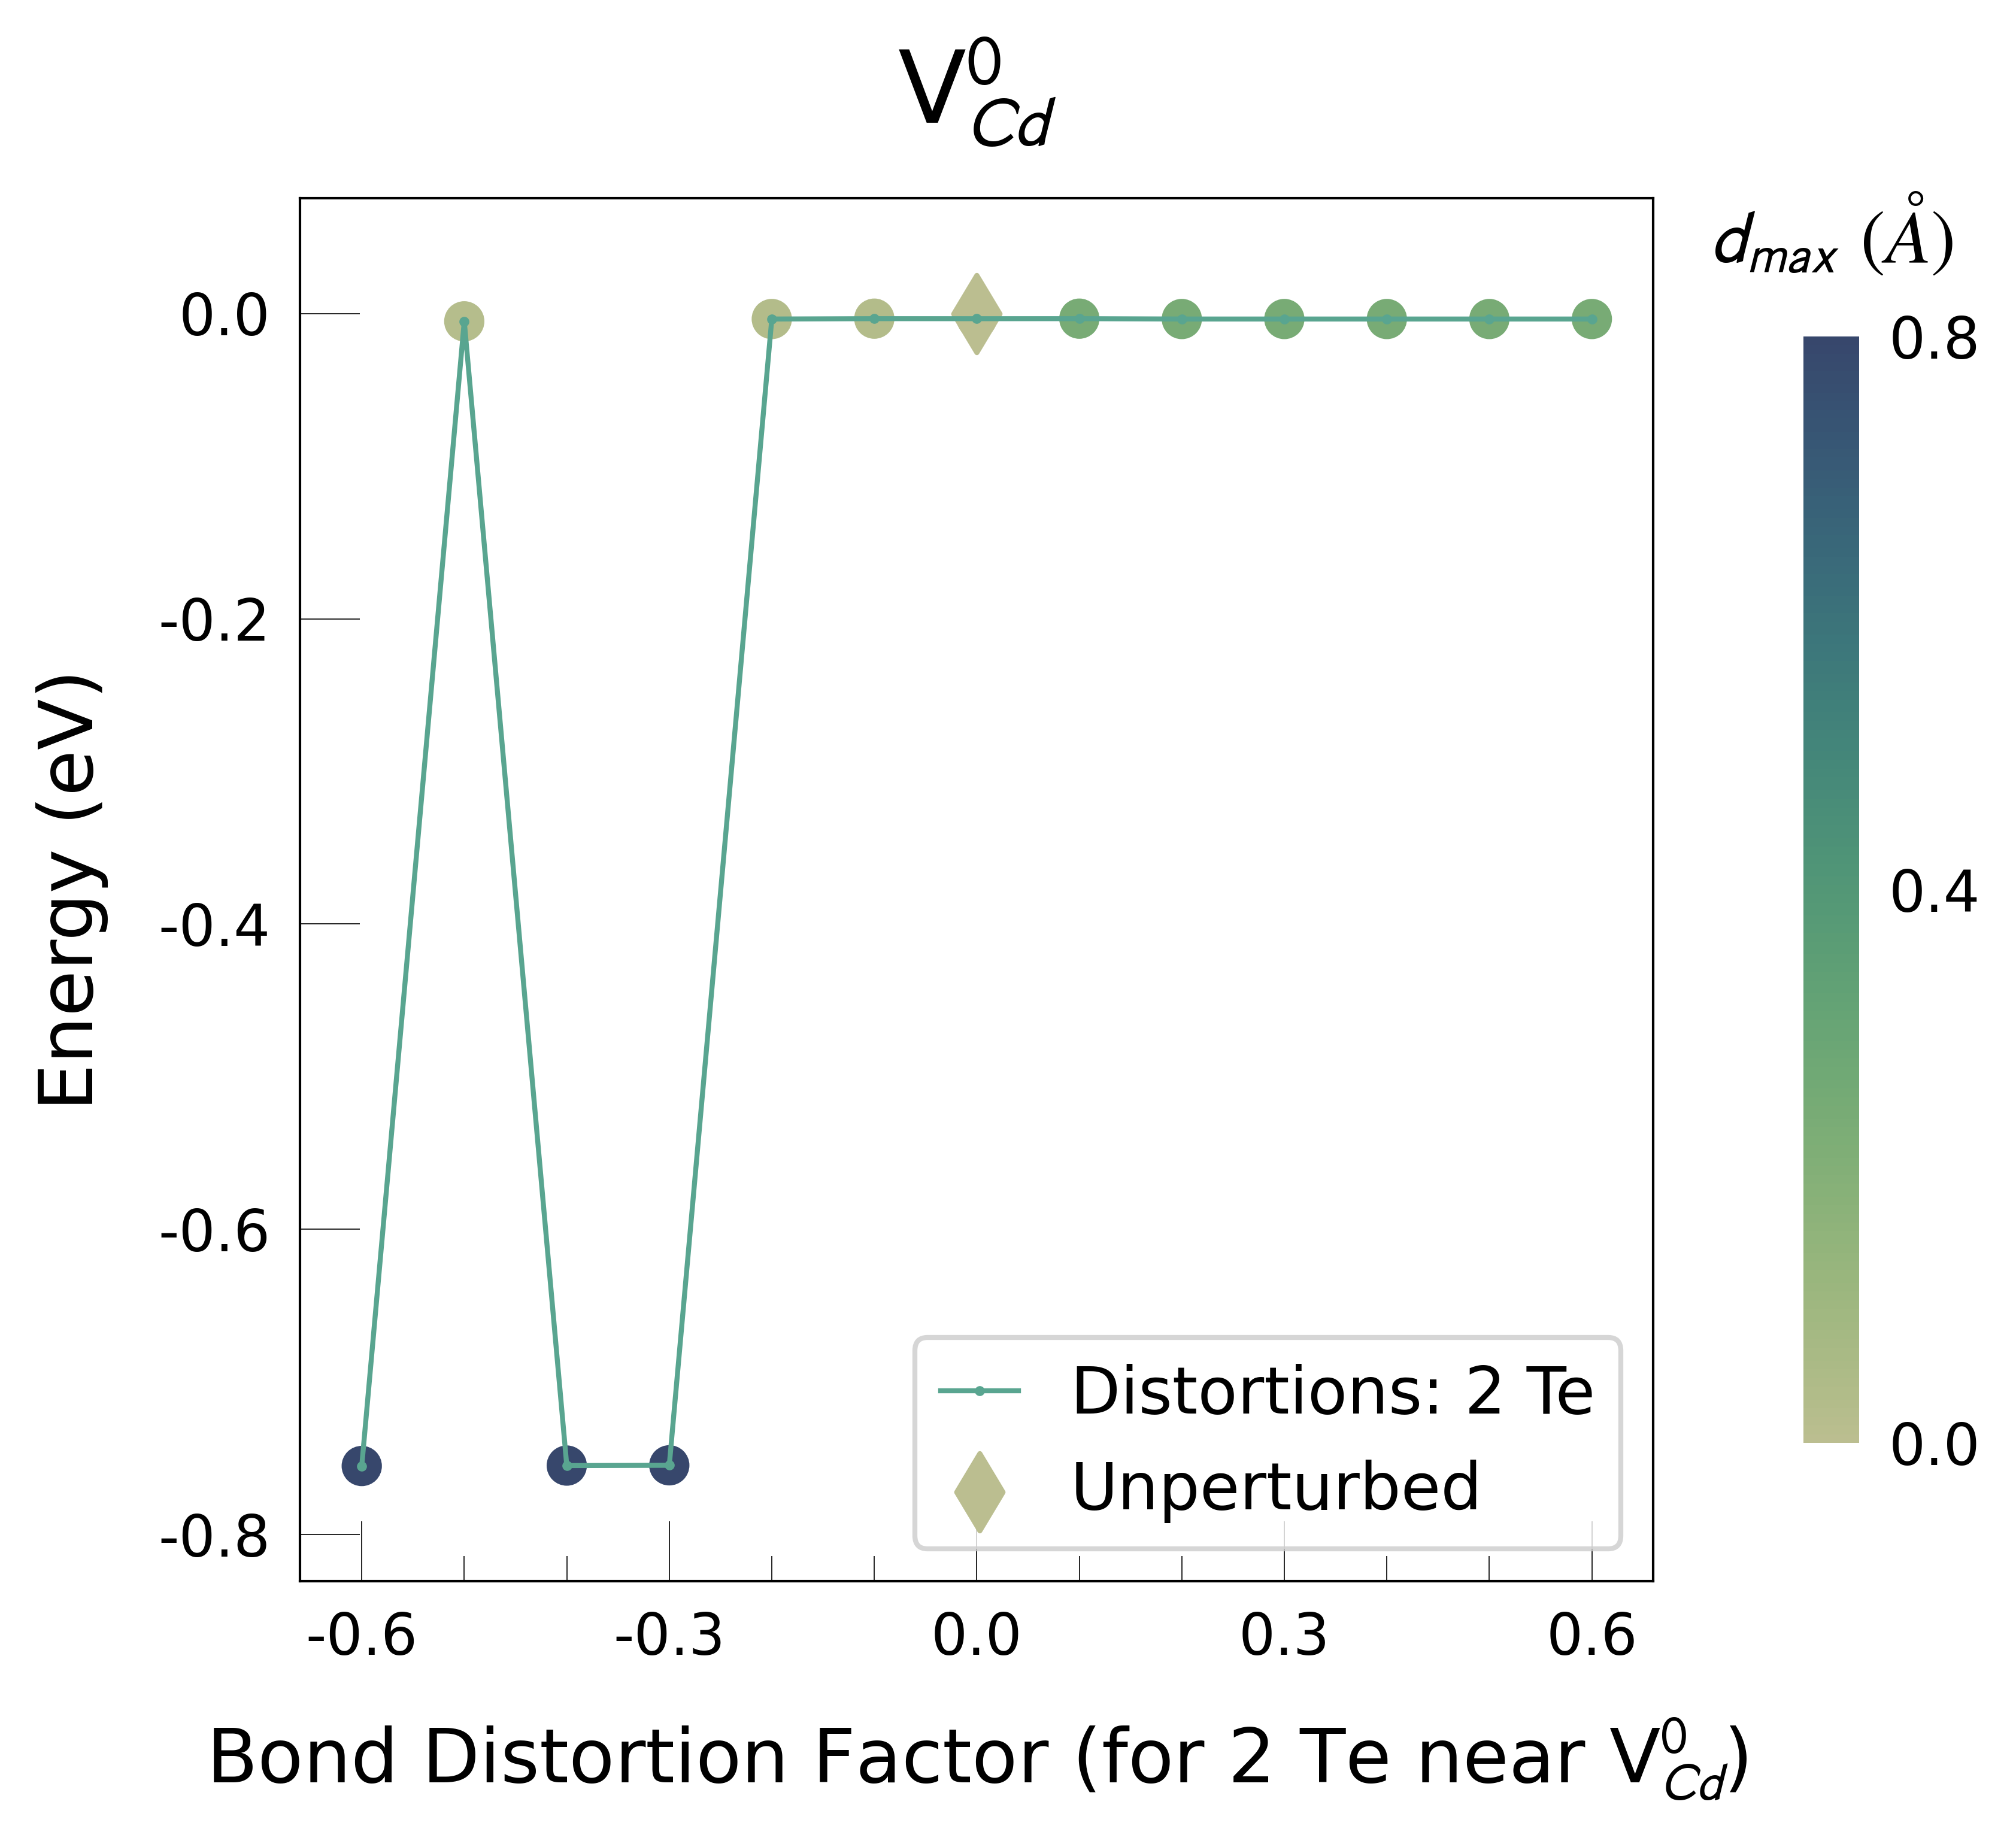

In [5]:
figs = plotting.plot_all_defects(
    defect_charges_dict,
    add_colorbar=True
)

plotting.py:754: UserWarning: Path ./vac_1_Ti_0/vac_1_Ti_0.yaml does not exist. Skipping vac_1_Ti_0.


Comparing structures to Unperturbed...
Plot saved to /home/ireaml/Python_Modules/shakenbreak/tutorials/distortion_plots/
Comparing structures to Unperturbed...
Plot saved to /home/ireaml/Python_Modules/shakenbreak/tutorials/distortion_plots/


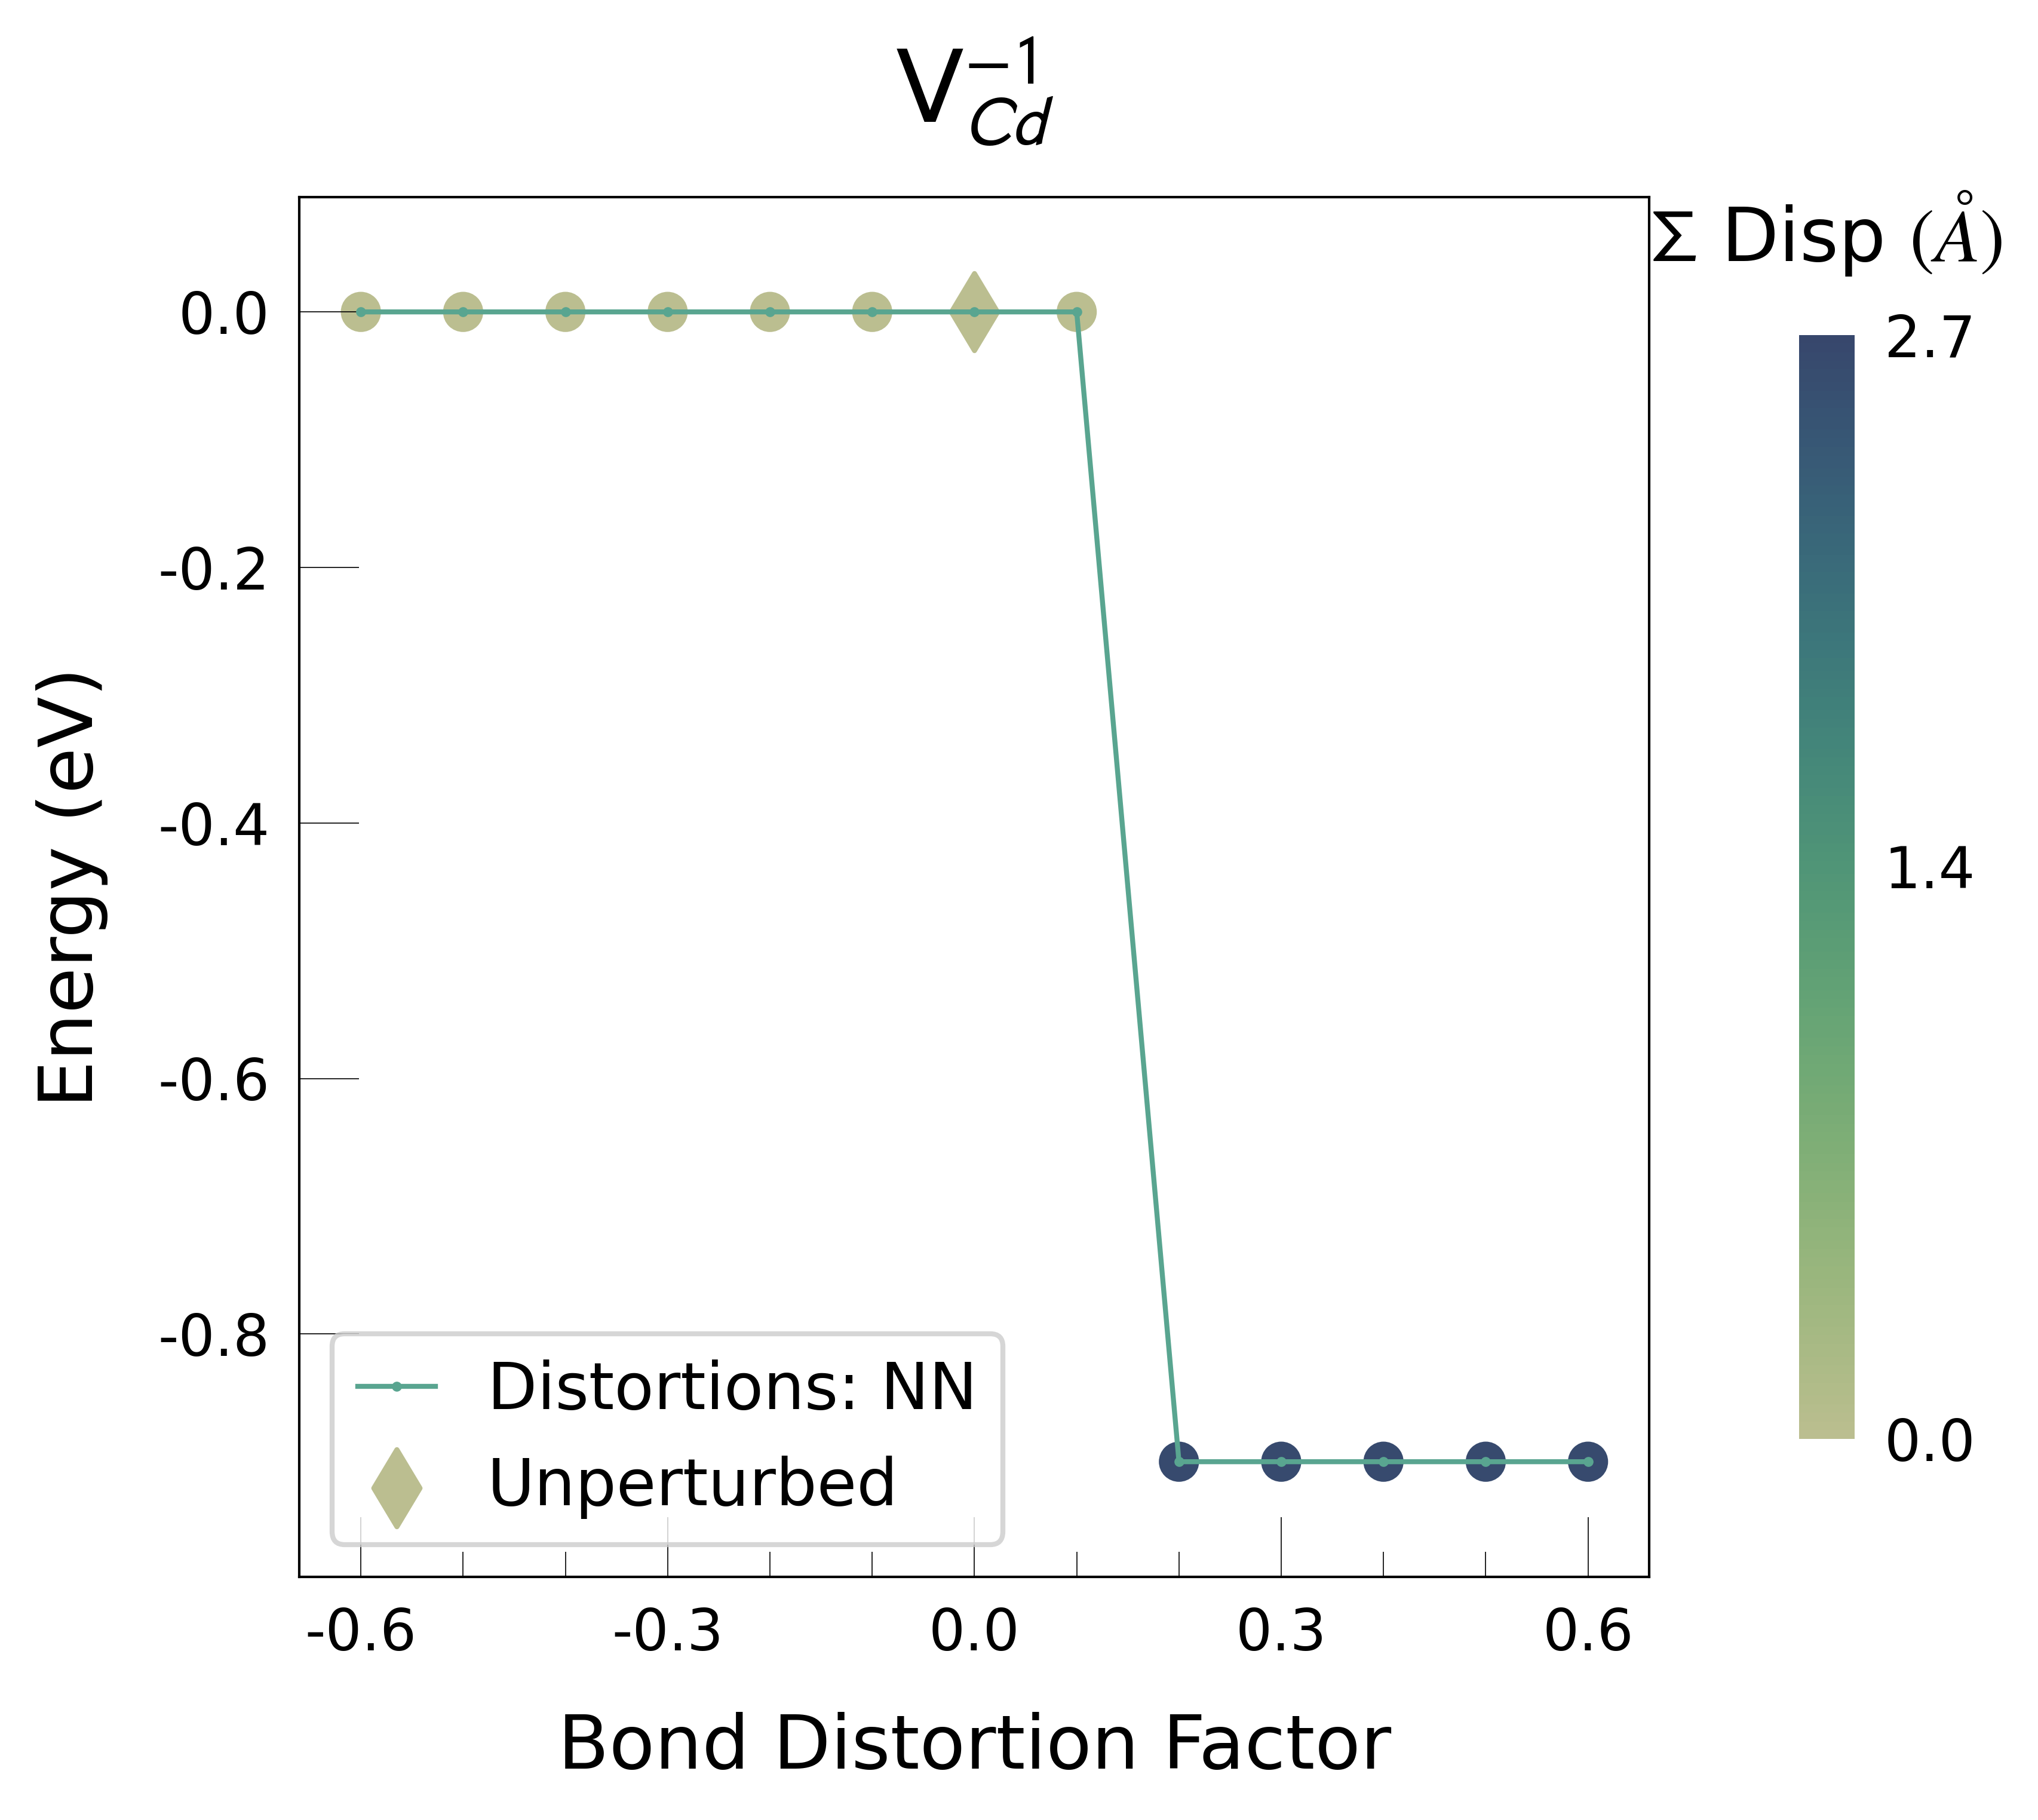

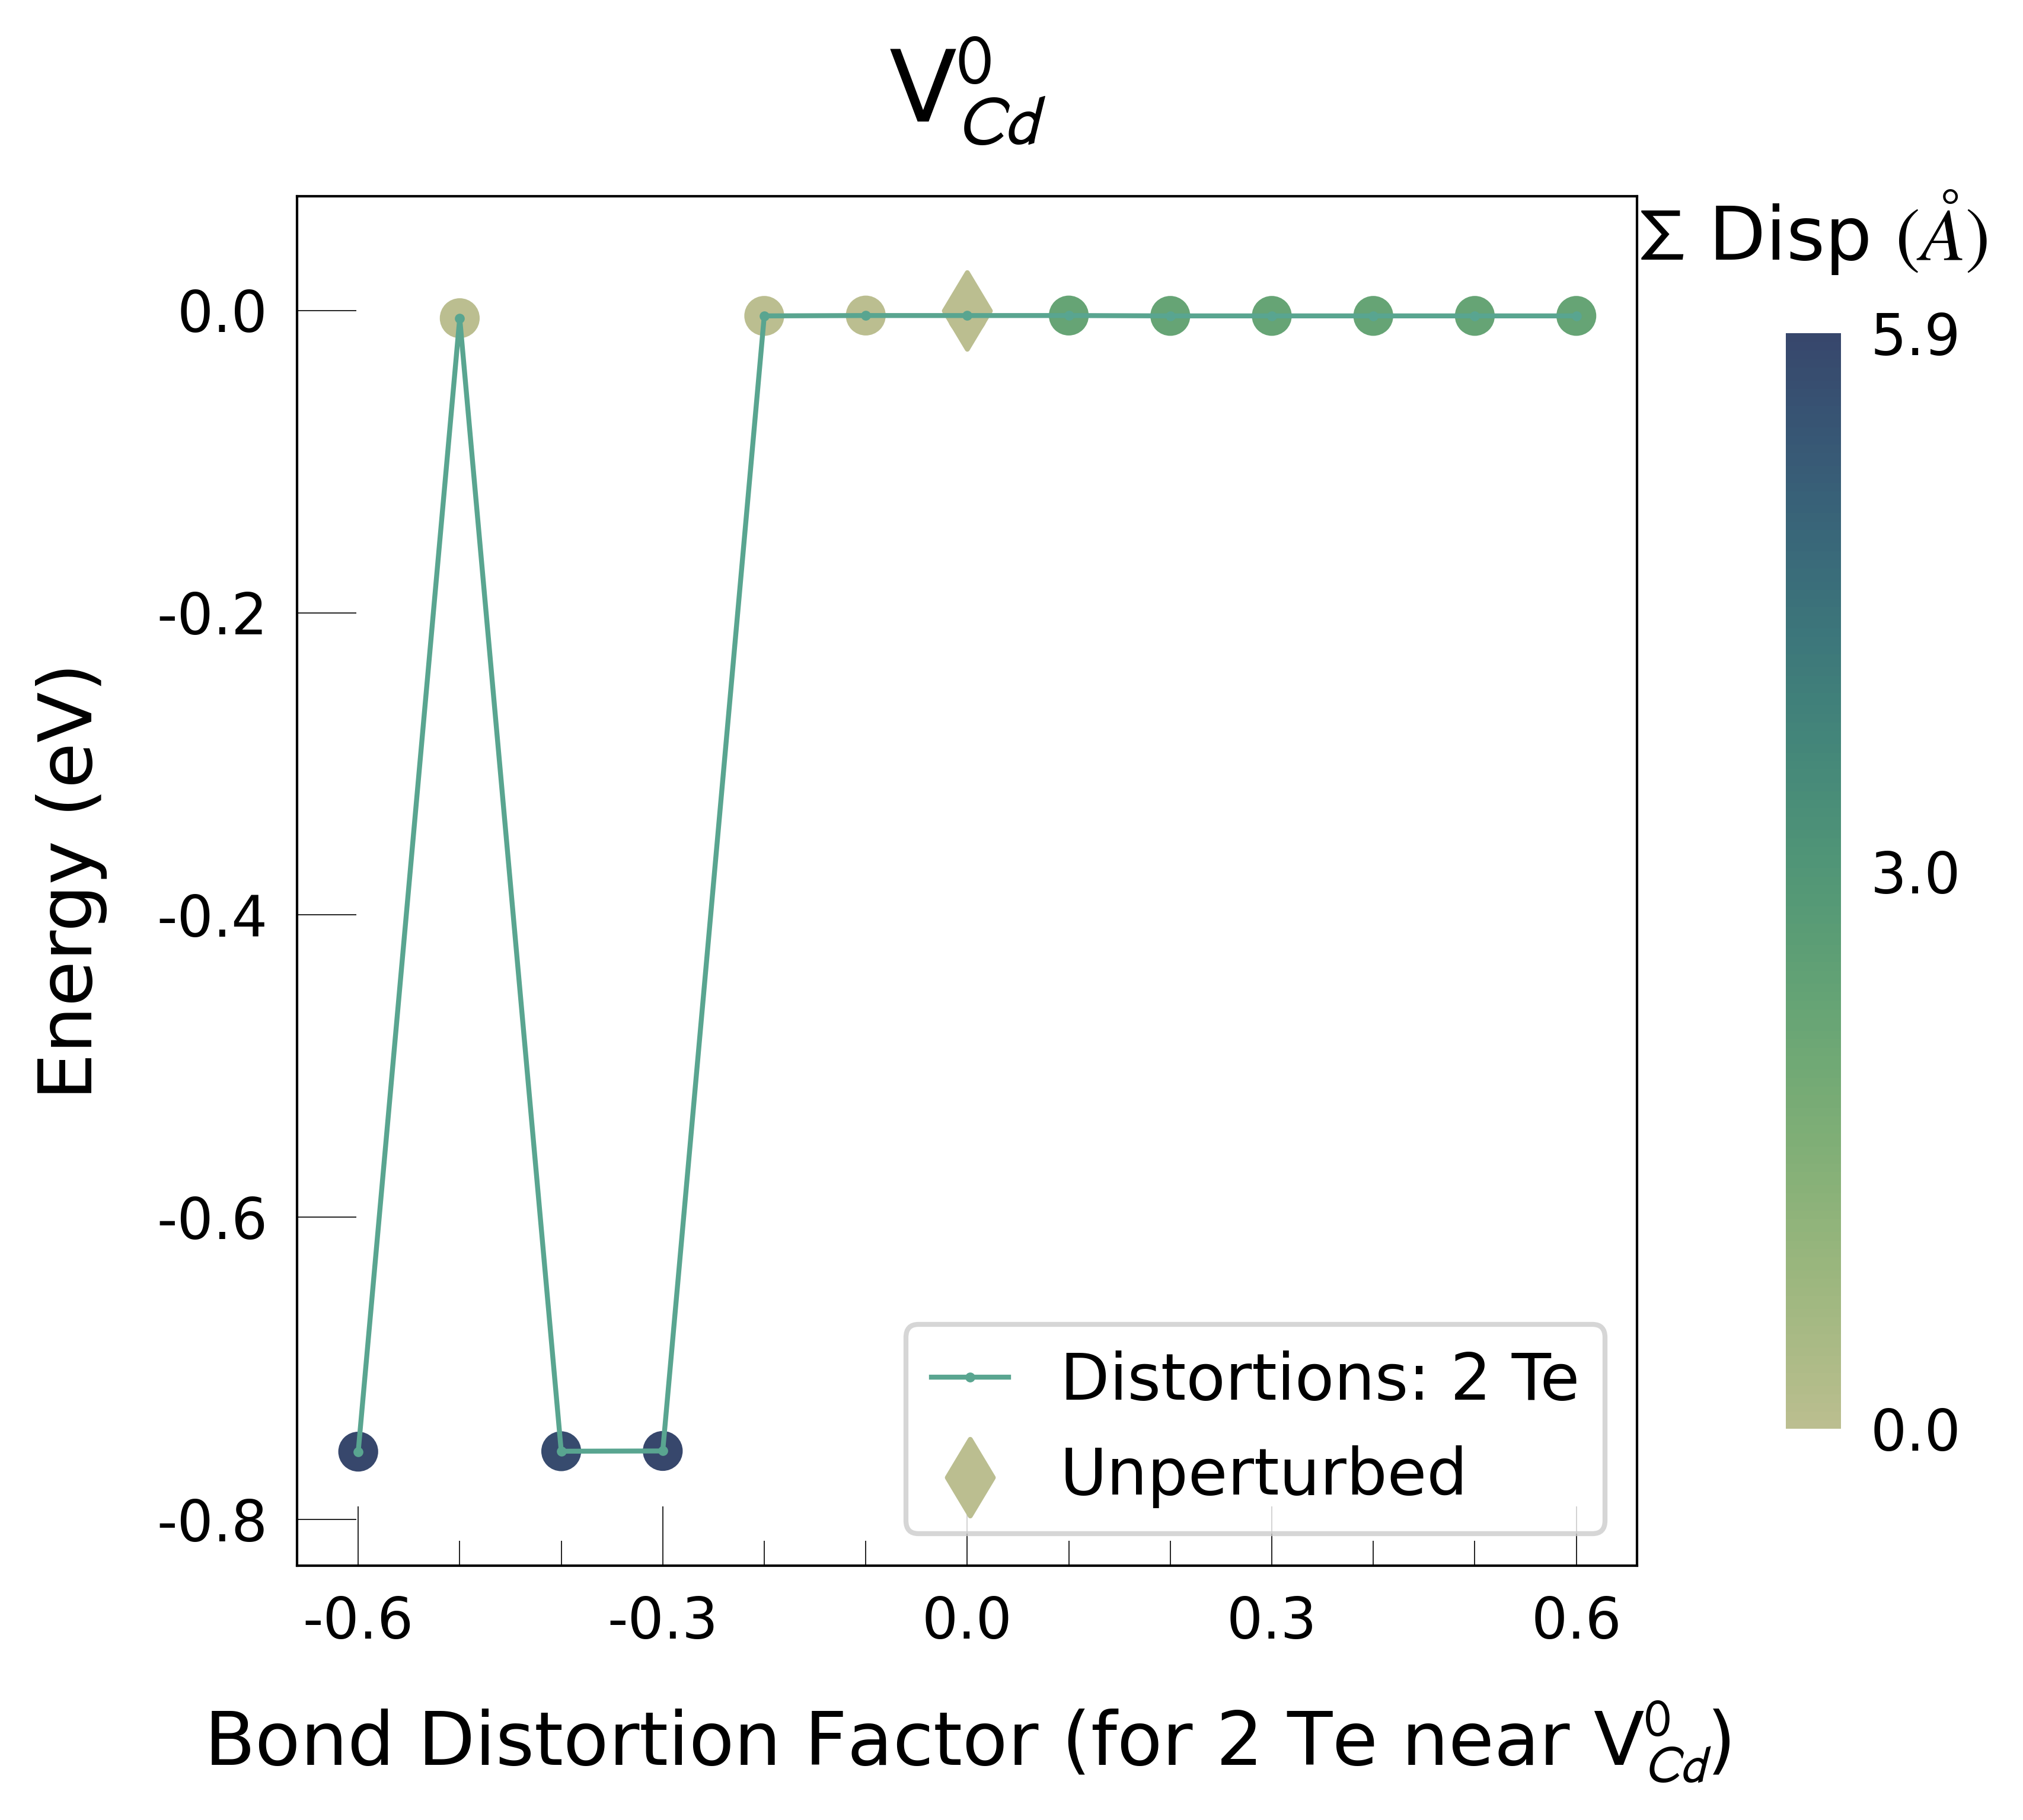

In [6]:
figs = plotting.plot_all_defects(
    defect_charges_dict,
    add_colorbar=True,
    metric="disp"
)

So for these example results, we find energy lowering distortions for $V_{Cd}^0$ (at -0.3, -0.4 and -0.6 bond distortion factors) and $V_{Cd}^{-1}$ (from 0.2 to 0.6 bond distortion factors). We should re-test these distorted structures for the $V_{Cd}$ charge states where these distortions were not found, in case they also give lower energies. 

Of course, this is not necessary if these structures were already found in the distortion tests for the other charge states, and so the `get_energy_lowering_distortions()` function automatically performs structure comparisons to determine which distortions should be tested in other charge states of the same defect, and which have already been found (see docstring and code paper for more details). 

In the output of `get_energy_lowering_distortions()` (which we saved to `low_energy_defects` in the earlier cell), we get a dictionary of defects for which bond distortion found an energy-lowering distortion (which is missed with normal unperturbed relaxation), of the form {defect: [list of distortion dictionaries (with corresponding charge states, energy lowering, distortion factors, structures and charge states for which these structures weren't found)]}.

For example, our results with $V_{Cd}$ show that we found an energy-lowering distortion for the neutral case (`charges`) which wasn't found with the -2 or -1 charge states (`excluded_charges`) – and so we'll test this distorted structures with those charge states – and also an energy-lowering distortion for -1 which wasn't found with 0 or -2 charge states.

In [111]:
for index, subdict in enumerate(low_energy_defects["vac_1_Cd"]):
    print(f"Energy lowering distortion number {index}")
    print("Found for charge states:", subdict["charges"])  # Charge state for which the energy lowering was found
    print(f"Not found in:", subdict["excluded_charges"], "\n")

Energy lowering distortion number 0
Found for charge states: [-1]
Not found in: {0, -2} 

Energy lowering distortion number 1
Found for charge states: [0]
Not found in: {-1, -2} 



This generates the new distorted structures and VASP inputs, to do our quick second round of structure testing (energy-lowering distortions found for at least one, but not all charge states for a given defect):

In [98]:
energy_lowering_distortions.write_distorted_inputs(low_energy_defects)

Writing low-energy distorted structure to ./vac_1_Cd_0/Bond_Distortion_20.0%_from_-1
Writing low-energy distorted structure to ./vac_1_Cd_-2/Bond_Distortion_20.0%_from_-1
No subfolders with VASP input files found in ./vac_1_Cd_-2, so just writing distorted POSCAR file to ./vac_1_Cd_-2/Bond_Distortion_20.0%_from_-1 directory.
Writing low-energy distorted structure to ./vac_1_Cd_-1/Bond_Distortion_-60.0%_from_0
No subfolders with VASP input files found in ./vac_1_Cd_-1, so just writing distorted POSCAR file to ./vac_1_Cd_-1/Bond_Distortion_-60.0%_from_0 directory.
Writing low-energy distorted structure to ./vac_1_Cd_-2/Bond_Distortion_-60.0%_from_0
No subfolders with VASP input files found in ./vac_1_Cd_-2, so just writing distorted POSCAR file to ./vac_1_Cd_-2/Bond_Distortion_-60.0%_from_0 directory.


Again we run the calculations on the HPCs, then parse and download the data to our local folders (but again in this example notebook we'll use our fake example data **_for demonstration purposes_** as in the next cell, but don't do this if you're actually running the calculations!)

In [64]:
!cp ./vac_1_Cd_0/vac_1_Cd_0_additional_distortions.yaml ./vac_1_Cd_0/vac_1_Cd_0.yaml
!cp ./vac_1_Cd_-1/vac_1_Cd_-1_additional_distortions.yaml ./vac_1_Cd_-1/vac_1_Cd_-1.yaml
!cp ./vac_1_Cd_-2/vac_1_Cd_-2_additional_distortions.yaml ./vac_1_Cd_-2/vac_1_Cd_-2.yaml
!cp ./vac_1_Cd_0/Bond_Distortion_-60.0%/CONTCAR ./vac_1_Cd_-1/Bond_Distortion_-60.0%_from_0/
!cp ./vac_1_Cd_0/Bond_Distortion_-60.0%/CONTCAR ./vac_1_Cd_-2/Bond_Distortion_-60.0%_from_0/
!cp ./vac_1_Cd_-1/Unperturbed/CONTCAR ./vac_1_Cd_-2/Bond_Distortion_20.0%_from_-1/
!cp ./vac_1_Cd_-1/Unperturbed/CONTCAR ./vac_1_Cd_0/Bond_Distortion_20.0%_from_-1/

cp: cannot stat './vac_1_Cd_0/vac_1_Cd_0_additional_distortions.yaml': No such file or directory
cp: cannot stat './vac_1_Cd_0/Bond_Distortion_-60.0%/CONTCAR': No such file or directory
cp: cannot stat './vac_1_Cd_0/Bond_Distortion_-60.0%/CONTCAR': No such file or directory
cp: cannot create regular file './vac_1_Cd_0/Bond_Distortion_20.0%_from_-1/': No such file or directory


Then re-parse with the same `get_energy_lowering_distortions()` function from before:

In [54]:
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(defect_charges_dict)


vac_1_Ti
No data parsed for vac_1_Ti_0. This species will be skipped and will not be included in the low_energy_defects charge state lists (and so energy lowering distortions found for other charge states will not be applied for this species).

vac_1_Cd
vac_1_Cd_-1: Energy difference between minimum, found with -60.0%_from_0 bond distortion, and unperturbed: -1.20 eV.
Energy lowering distortion found for vac_1_Cd with charge -1. Adding to low_energy_defects dictionary.
vac_1_Cd_-2: Energy difference between minimum, found with 20.0%_from_-1 bond distortion, and unperturbed: -1.90 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...


analysis.py:248: UserWarning: Path ./vac_1_Ti_0/vac_1_Ti_0.yaml does not exist


New (according to structure matching) low-energy distorted  structure found for vac_1_Cd_-2, adding to low_energy_defects['vac_1_Cd'] list.
No data parsed for vac_1_Cd_0. This species will be skipped and will not be included in the low_energy_defects charge state lists (and so energy lowering distortions found for other charge states will not be applied for this species).

Comparing and pruning defect structures across charge states...
Comparing structures to specified ref_structure (Cd31 Te32)...


analysis.py:251: UserWarning: No data parsed from ./vac_1_Cd_0/vac_1_Cd_0.yaml, returning None


Ground-state structure found for vac_1_Cd with charges [-1] has been also previously been found for charge state -2 (according to structure matching). Adding this charge to the corresponding entry in low_energy_defects[vac_1_Cd].
Comparing structures to specified ref_structure (Cd31 Te32)...
Ground-state structure found for vac_1_Cd with charges [-2] has been also previously been found for charge state -1 (according to structure matching). Adding this charge to the corresponding entry in low_energy_defects[vac_1_Cd].


Finally we can replot the results from all our distortion tests:

plotting.py:733: UserWarning: Path ./distortion_metadata.json does not exist. Will not parse its contents.
plotting.py:752: UserWarning: Path ./vac_1_Ti_0/vac_1_Ti_0.yaml does not exist. Skipping vac_1_Ti_0.
plotting.py:900: UserWarning: Path ./distortion_metadata.json does not exist. Will not parse its contents.


Plot saved to /home/ireaml/Python_Modules/shakenbreak/distortion_plots/


plotting.py:900: UserWarning: Path ./distortion_metadata.json does not exist. Will not parse its contents.


Plot saved to /home/ireaml/Python_Modules/shakenbreak/distortion_plots/


analysis.py:251: UserWarning: No data parsed from ./vac_1_Cd_0/vac_1_Cd_0.yaml, returning None
plotting.py:762: UserWarning: Unperturbed calculation for vac_1_Cd_0 not converged! Skipping plot.


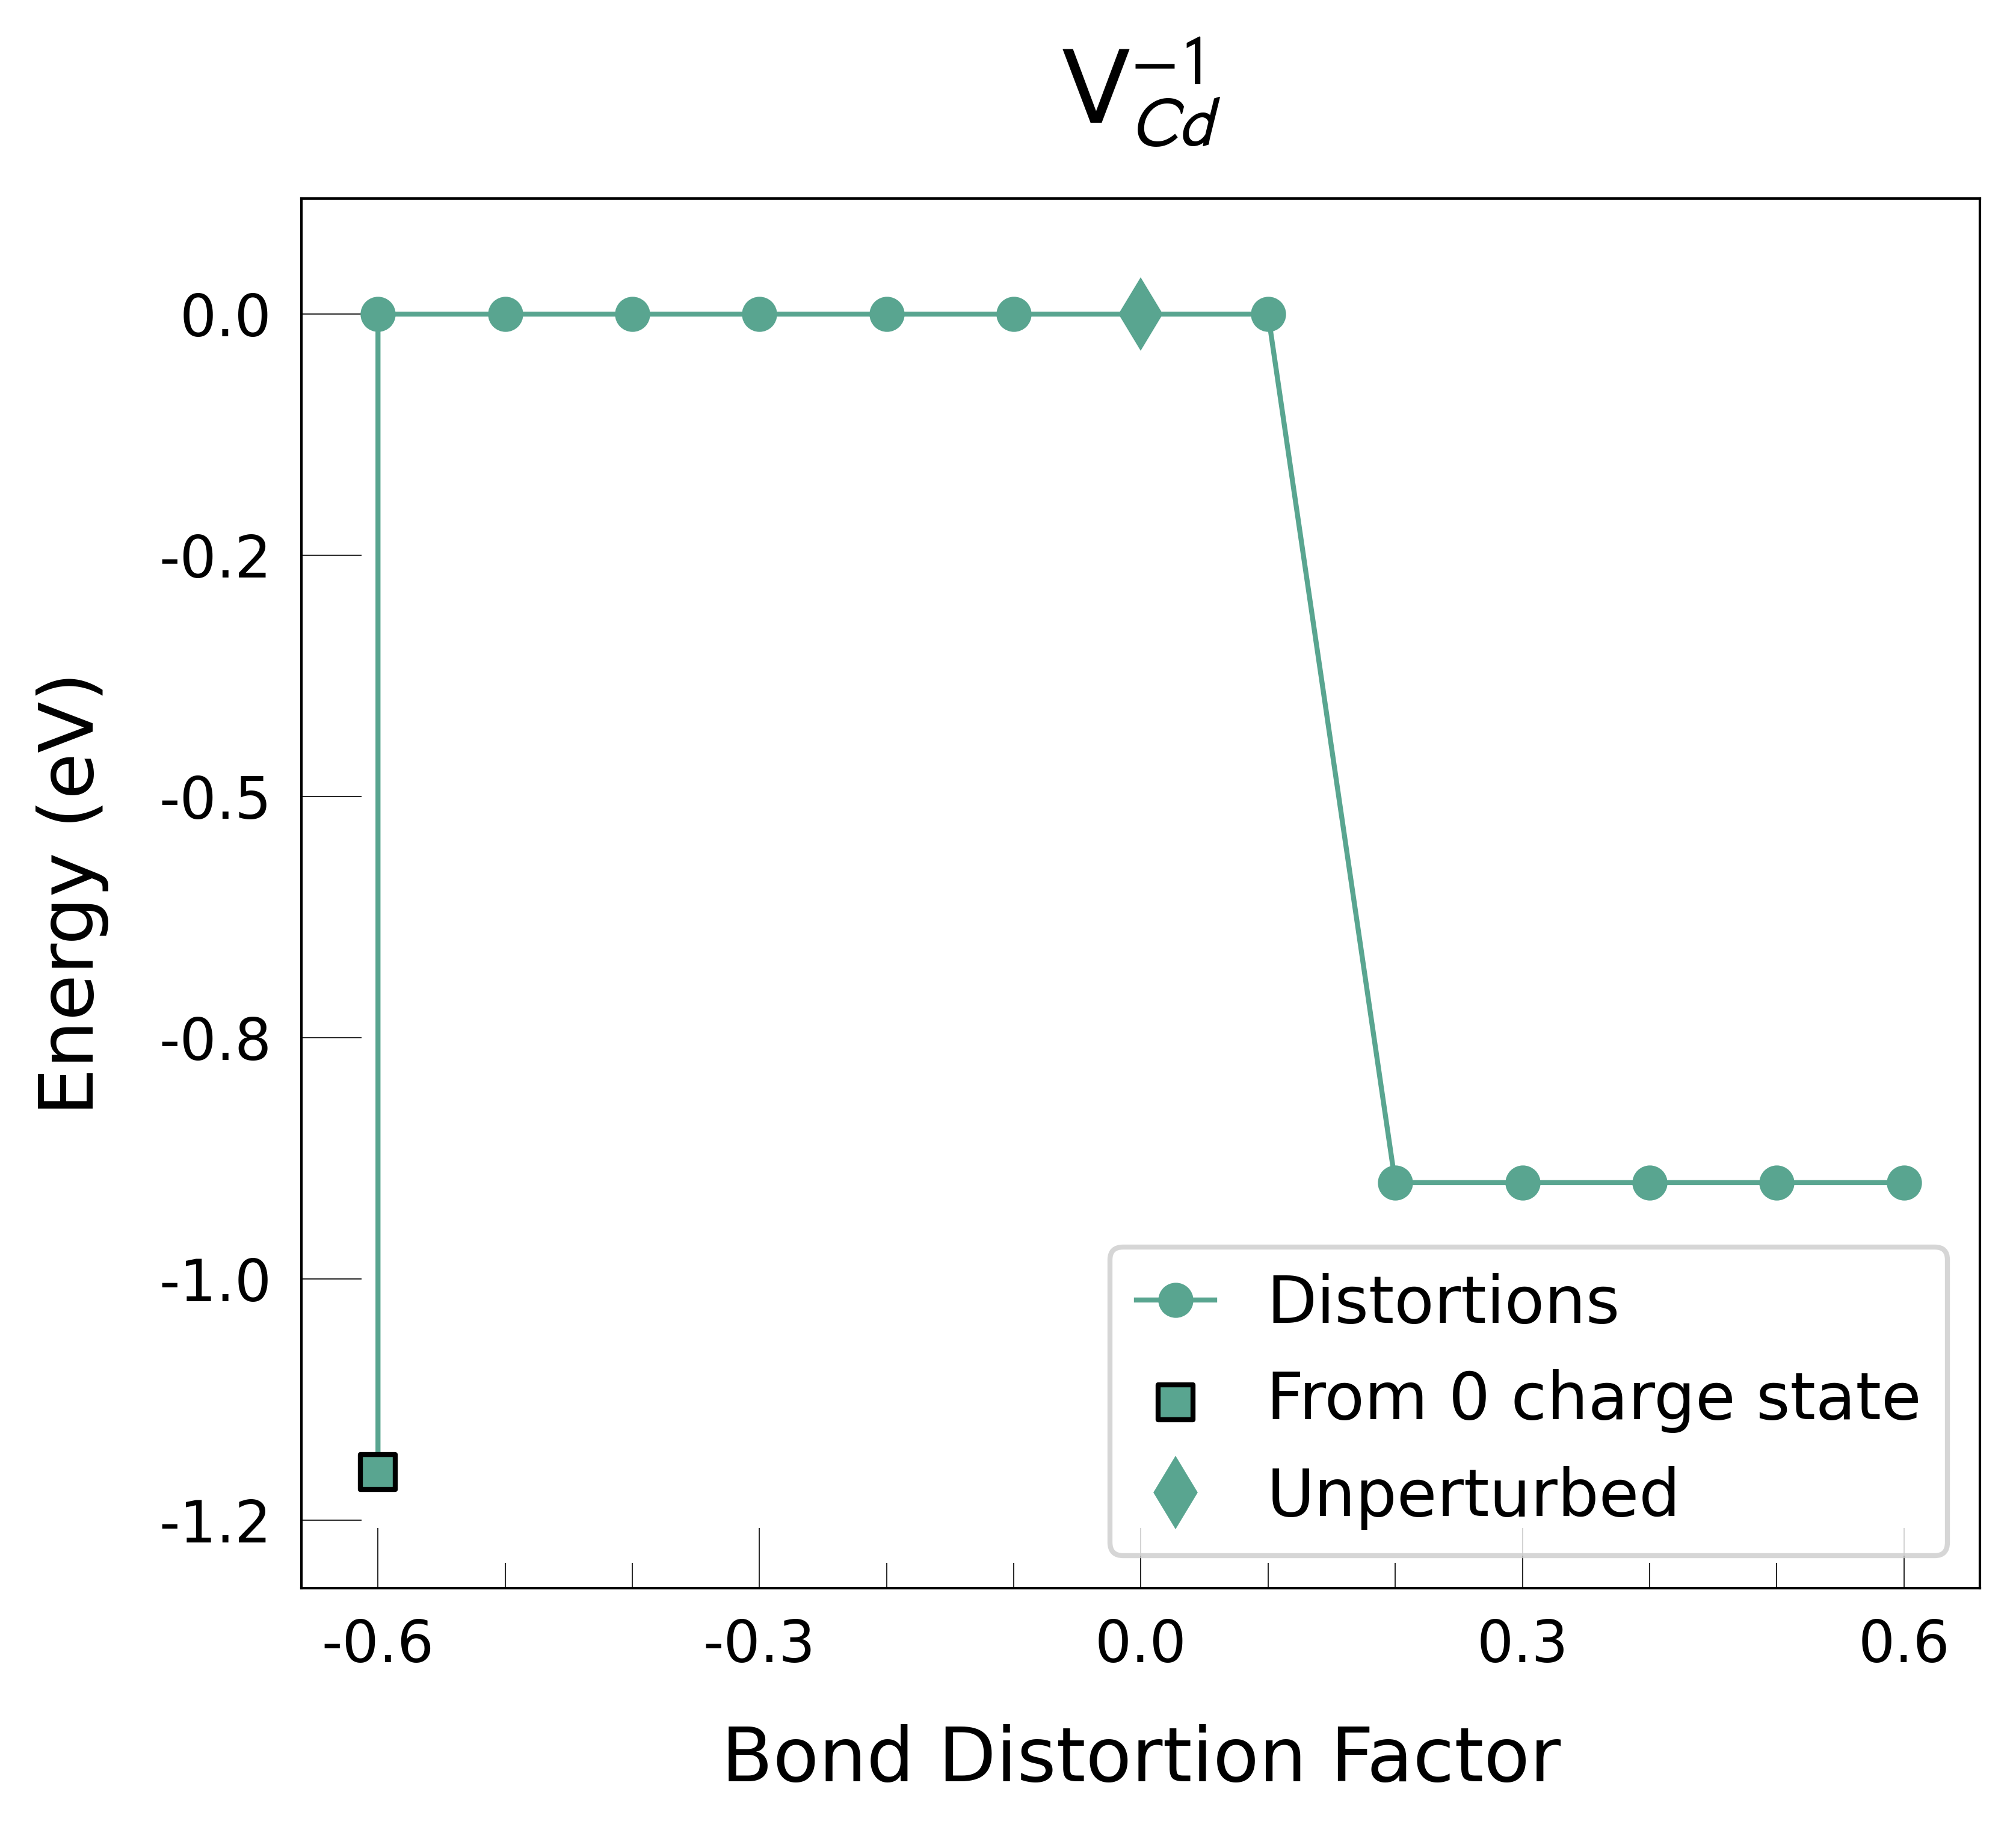

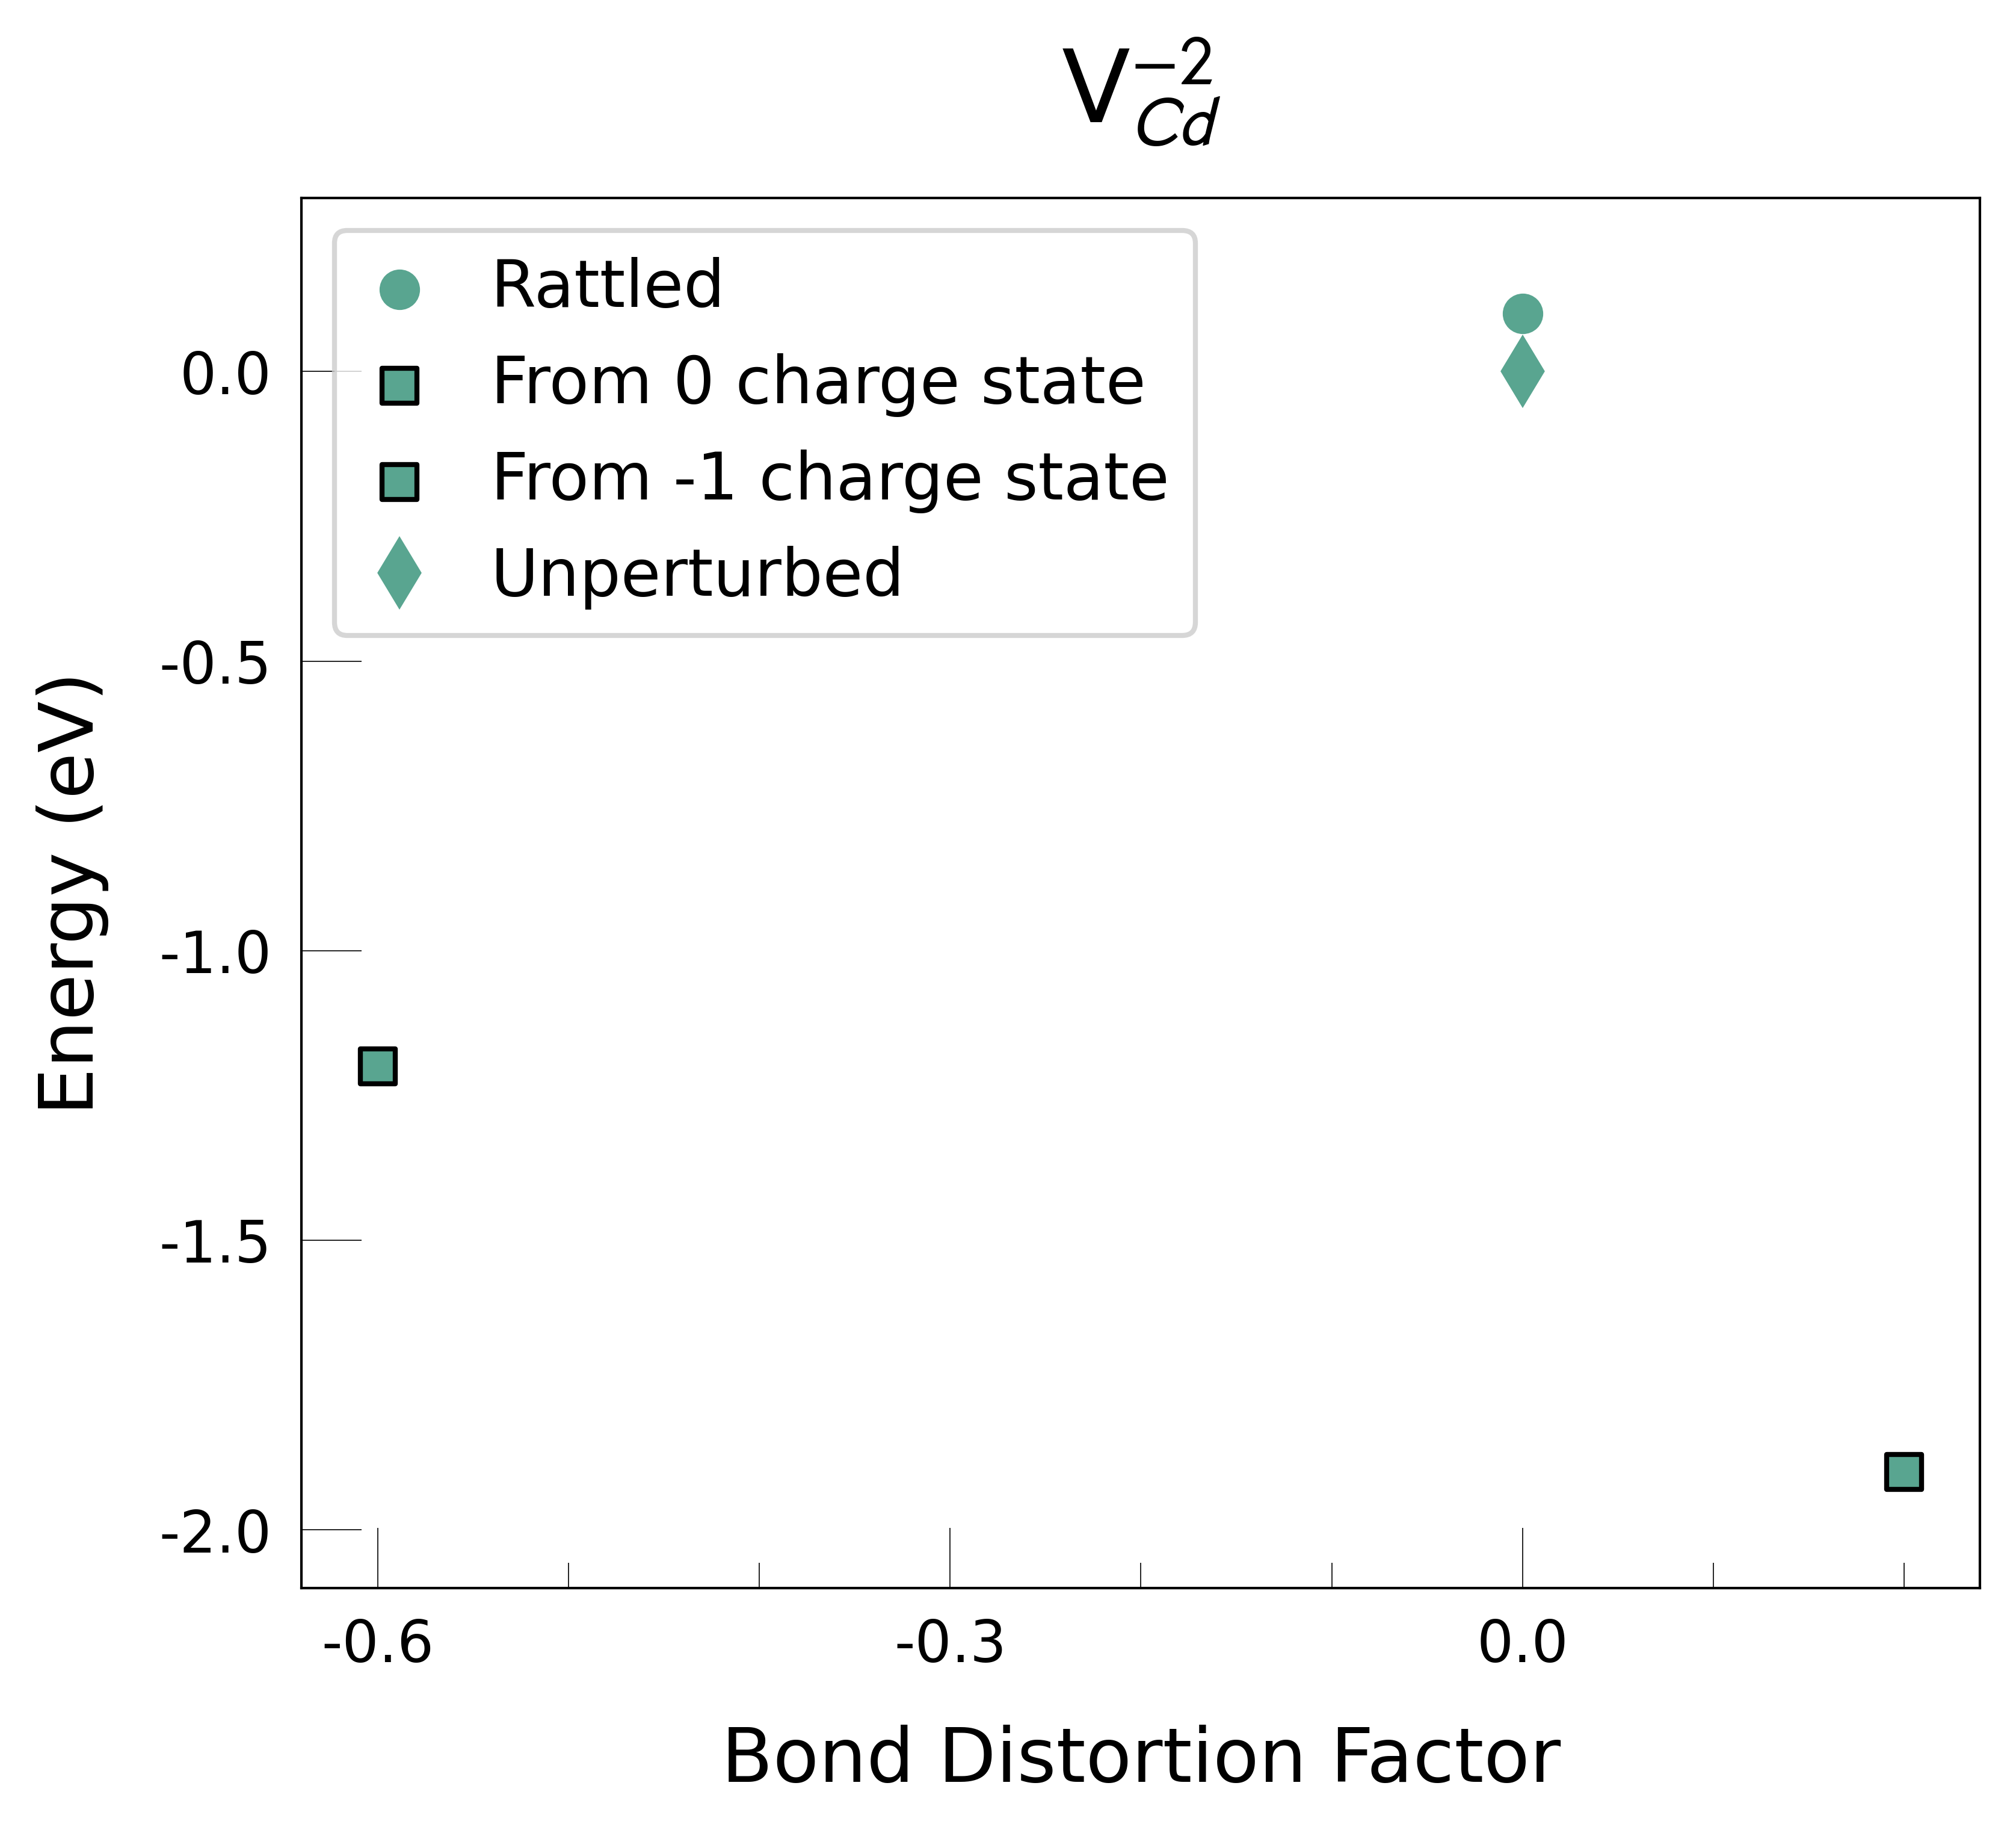

In [56]:
figs = plotting.plot_all_defects(defect_charges_dict)

In this example case, for $V_{Cd}^{0}$ the distorted structure originally found for the -1 charge state comes out lower energy than the $V_{Cd}^{0}$ unperturbed relaxation, but still higher energy than the previously identified ground-state at -0.3, -0.4 and -0.6 distortion factors. 

For $V_{Cd}^{-1}$, the distorted structure originally found for the neutral (0) charge state comes out lower energy than the previously identified ground-state at distortion factors >0.2.

We now continue our defect calculations using the ground-state `CONTCAR`s we've obtained for each defect, with our fully-converged `INCAR` and `KPOINTS` settings.

<a id='analyse'></a>

## 5. *Optional*: Analyse the defect distortions found with `SnB`

If we want to analyse in more detail the defect distortions identified with our structure searching, we can use some of the functions from `shakenbreak.analysis`:

In [7]:
from shakenbreak import analysis

# Parse all structures obtained with distortions and unperturbed relaxation.   
# This gives a dictionary matching initial distortion to final structure
vac_1_Cd_0 = analysis.get_structures("vac_1_Cd_0")

In [8]:
# Can then analyse a chosen final structure with:
df = analysis.analyse_structure("vac_1_Cd_0", vac_1_Cd_0["Unperturbed"])
df = analysis.analyse_structure("vac_1_Cd_0", vac_1_Cd_0[-0.4])

vac_1_Cd_0 structural analysis 
Analysing site V [0. 0. 0.]
Local order parameters (i.e. resemblance to given structural motif, via CrystalNN):


,Coordination,Factor
0,square co-planar,0.085138
1,tetrahedral,0.999723
2,rectangular see-saw-like,0.008200
3,see-saw-like,0.241093
4,trigonal pyramidal,0.252129



Bond-lengths (in Å) to nearest neighbours: 


,Element,Distance
0,Te,2.597
1,Te,2.627
2,Te,2.627
3,Te,2.652



vac_1_Cd_0 structural analysis 
Analysing site V [0. 0. 0.]
Local order parameters (i.e. resemblance to given structural motif, via CrystalNN):


,Coordination,Factor
0,square co-planar,0.125216
1,tetrahedral,0.737708
2,rectangular see-saw-like,0.030893
3,see-saw-like,0.205372
4,trigonal pyramidal,0.213782



Bond-lengths (in Å) to nearest neighbours: 


,Element,Distance
0,Te,2.192
1,Te,2.635
2,Te,2.635
3,Te,2.296


We can also compare the structural similarity between all structures with `compare_structures()`. It prints the summed root mean squared displacement,
maximum distance between paired sites, and energy (relative to unperturbed structure) of all final structures:

In [9]:
defect_energies = analysis.get_energies("vac_1_Cd_0")
structure_comparison = analysis.compare_structures(
    vac_1_Cd_0,
    defect_energies
)

vac_1_Cd_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Comparing structures to Unperturbed...


,Bond Distortion,Σ{Displacements} (Å),Max Distance (Å),Δ Energy (eV)
0,-0.6,5.873,0.810,-0.76
1,-0.5,0.000,0.024,-0.01
2,-0.4,5.760,0.808,-0.75
3,-0.3,5.872,0.808,-0.75
4,-0.2,0.000,0.025,0.00
5,-0.1,0.000,0.028,0.00
6,0.0,0.000,0.030,0.00
7,0.1,2.285,0.237,0.00
8,0.2,2.285,0.237,0.00
9,0.3,2.285,0.237,0.00


Highly favourable distortions are often driven by some kind of rebonding. For most vacancies and interstitials, this entails formation of new homoionic bonds between the defect neighbours.
We can quickly check for these reconstructions using `analysis.get_homoionic_bonds()`

In [10]:
bonds = analysis.get_homoionic_bonds(
    structure=vac_1_Cd_0[-0.4], # Structure to analyse
    element="Te", # we're looking for Te-Te bonds
    radius=2.8, # maximum bond distance between 2 Te
    verbose=False, # don't print bond distances
)
print(bonds)
print("So two of the vacancy neighbours formed a Te-Te bond to compensate for the charge deficiency")

{'Te(32)': {'Te(41)': '2.75 A'}}
So two of the vacancy neighbours formed a Te-Te bond to compensate for the charge deficiency


For defects that can result in polarons, we can check the sites with significant magnetization using `analysis.get_site_magnetizations()`

In [11]:
df = analysis.get_site_magnetizations(
    defect_species="vac_1_Ti_0", # neutral Ti vacancy in anatase TiO2
    distortions=["Unperturbed", -0.4],
    defect_site=[0.0, 0.16666666666666669, 0.25],
    threshold=0.3, # to filter sites with significant magnetization
    orbital_projections=False, # don't show orbital projections
)

display(df["Unperturbed"]) # 4 holes localised on 4 of the vacancy neighbours
print("So we have 4 holes localised on 4 of the oxygen ions neighbouring the vacancy")

Analysing distortion Unperturbed. Total magnetization: 4.0
Analysing distortion -0.4. Total magnetization: -0.0
No significant magnetizations found for distortion: -0.4 



,Site,Coords,Total mag,Dist. (A)
O(35),O(35),"[0.0, 0.167, 0.014]",1.458,2.3
O(53),O(53),"[-0.0, 0.167, 0.486]",1.478,2.3
O(62),O(62),"[0.165, 0.167, 0.292]",1.522,1.9
O(68),O(68),"[0.835, 0.167, 0.292]",1.521,1.9


So we have 4 holes localised on 4 of the oxygen ions neighbouring the vacancy


As printed below, no significant magnetization is found for -40.0% distortion. This configuration was found to be significantly more stable than the polaronic solution, so we can quickly use `analysis.get_homoionic_bonds` to see why:

In [12]:
bonds = analysis.get_homoionic_bonds(
    structure = Structure.from_file("./vac_1_Ti_0/Bond_Distortion_-40.0%/CONTCAR"),
    element="O",
    radius=2.0,
    verbose=False,
)
print(bonds)
print("So the formation of an O-O bond drived this distortion")

{'O(44)': {'O(62)': '1.2 A'}}
So the formation of an O-O bond drived this distortion


See the [documentation](https://shakenbreak.readthedocs.io/en/latest/) for more info and optional parameter choices etc